# Aviation Risk Assessment

The purpose of this project is to evaluate the risk of aircraft for a stakeholder considering the purchase & operation of private & commercial aircraft. Using the NTSB dataset on all aircraft incidents in and around the US since 1962 [found here](https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses), I evaluate and clean the data, narrow the records down to the relevant aircraft, use a correlation map to find insights into the nature of lower-risk planes, then also bring in some exterior data considerations in order to recommend the following to the stakeholder:

- avoid light, single-engine aircraft
- recommend the lowest-risk aircraft among three capacity tiers with widley-varying investment amounts


# Importing libraries, reading in files, and starting in on exploratory data analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt

In [2]:
aviation_df = pd.read_csv('AviationData.csv',  encoding='latin1')
aviation_df

C:\Users\joelm\anaconda3again\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,7,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88884,20221227106491,Accident,ERA23LA093,2022-12-26,"Annapolis, MD",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,29-12-2022
88885,20221227106494,Accident,ERA23LA095,2022-12-26,"Hampton, NH",United States,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
88886,20221227106497,Accident,WPR23LA075,2022-12-26,"Payson, AZ",United States,341525N,1112021W,PAN,PAYSON,...,Personal,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022
88887,20221227106498,Accident,WPR23LA076,2022-12-26,"Morgan, UT",United States,NaN,NaN,NaN,NaN,...,Personal,MC CESSNA 210N LLC,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
state_codes_df = pd.read_csv('USState_Codes.csv')
state_codes_df

,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
...,...,...
57,Virgin Islands,VI
58,Washington_DC,DC
59,Gulf of mexico,GM
60,Atlantic ocean,AO


The aviation file seems to have almost everything we'll need while the state-code file just supplies some reference information. 

Let's look into some basic information about the aviation file now:

In [4]:
aviation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

It looks like missing values are usually found in location data, which may not factor *too* much into our inquiry into aircraft safety. However, other columns with missing data such as 'Aircraft.Category' or 'Broad.phase.of.flight' may need to be addressed once we find out more about what all of these columns mean. 

## More detailed EDA: finding out what each column means

In [5]:
aviation_df.columns

Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')

Some of these columns seem self-explanatory, but let's find out more about the ones whose content isn't immediately clear:

In [6]:
aviation_df['Investigation.Type'].unique()

array(['Accident', 'Incident'], dtype=object)

In [7]:
aviation_df['Investigation.Type'].value_counts()

Accident    85015
Incident     3874
Name: Investigation.Type, dtype: int64

So, there are only two types of investigations: accidents and incidents. There are a lot more accidents than incidents. 

Looking further online shows that **incidents** are the umbrella term; they're any kind of occurance that could or did affect the safety of operations, but usually not as serious as an **accident**, which is an incident "in which any person suffers death or serious injury, or in which the aircraft receives substantial damage.” 

Source: https://safetycompass.wordpress.com/2021/09/30/accident-or-incident-explaining-aircraft-damage-assessment/#:~:text=When%20an%20aircraft%20crashes%2C%20National,Regulations%20(CFR)%20Part%20830.

In [8]:
aviation_df['Injury.Severity'].unique()

array(['Fatal(2)', 'Fatal(4)', 'Fatal(3)', 'Fatal(1)', 'Non-Fatal',
       'Incident', 'Fatal(8)', 'Fatal(78)', 'Fatal(7)', 'Fatal(6)',
       'Fatal(5)', 'Fatal(153)', 'Fatal(12)', 'Fatal(14)', 'Fatal(23)',
       'Fatal(10)', 'Fatal(11)', 'Fatal(9)', 'Fatal(17)', 'Fatal(13)',
       'Fatal(29)', 'Fatal(70)', 'Unavailable', 'Fatal(135)', 'Fatal(31)',
       'Fatal(256)', 'Fatal(25)', 'Fatal(82)', 'Fatal(156)', 'Fatal(28)',
       'Fatal(18)', 'Fatal(43)', 'Fatal(15)', 'Fatal(270)', 'Fatal(144)',
       'Fatal(174)', 'Fatal(111)', 'Fatal(131)', 'Fatal(20)', 'Fatal(73)',
       'Fatal(27)', 'Fatal(34)', 'Fatal(87)', 'Fatal(30)', 'Fatal(16)',
       'Fatal(47)', 'Fatal(56)', 'Fatal(37)', 'Fatal(132)', 'Fatal(68)',
       'Fatal(54)', 'Fatal(52)', 'Fatal(65)', 'Fatal(72)', 'Fatal(160)',
       'Fatal(189)', 'Fatal(123)', 'Fatal(33)', 'Fatal(110)',
       'Fatal(230)', 'Fatal(97)', 'Fatal(349)', 'Fatal(125)', 'Fatal(35)',
       'Fatal(228)', 'Fatal(75)', 'Fatal(104)', 'Fatal(229)', 'Fatal

Looks like injury severity ranges from NaN to 'Indicent', 'Minor', 'Non-Fatal', 'Serious', and then either 'Fatal' without a count or 'Fatal' with a count. 

I found more info on what a 'serious' injury means: "any injury which: (1) Requires hospitalization for more than 48 hours, commencing within 7 days from the date of the injury was received; (2) results in a fracture of any bone (except simple fractures of fingers, toes, or nose); (3) causes severe hemorrhages, nerve, muscle, or tendon damage; (4) involves any internal organ; or (5) involves second- or third-degree burns, or any burns affecting more than 5 percent of the body surface."

Source: https://www.law.cornell.edu/cfr/text/49/830.2

In [9]:
aviation_df['Aircraft.damage'].unique()

array(['Destroyed', 'Substantial', 'Minor', nan, 'Unknown'], dtype=object)

In [10]:
#Let's change 'Unknown' to NaN since they're essentially NaN's:
aviation_df['Aircraft.damage'] = aviation_df['Aircraft.damage'].apply(lambda x: np.nan if x == 'Unknown' else x)
aviation_df['Aircraft.damage'].unique()

array(['Destroyed', 'Substantial', 'Minor', nan], dtype=object)

In [11]:
aviation_df['Aircraft.Category'].unique()

array([nan, 'Airplane', 'Helicopter', 'Glider', 'Balloon', 'Gyrocraft',
       'Ultralight', 'Unknown', 'Blimp', 'Powered-Lift', 'Weight-Shift',
       'Powered Parachute', 'Rocket', 'WSFT', 'UNK', 'ULTR'], dtype=object)

Since our inquiry is related to passenger planes, we'll drop the records that aren't relevant:

In [12]:
aviation_df = aviation_df.loc[aviation_df['Aircraft.Category'] == 'Airplane']
aviation_df['Aircraft.Category'].unique()

array(['Airplane'], dtype=object)

In [13]:
aviation_df['Amateur.Built'].unique()

array(['No', 'Yes', nan], dtype=object)

In [14]:
aviation_df['Amateur.Built'].value_counts()

No     24417
Yes     3183
Name: Amateur.Built, dtype: int64

It turns out that "amateur-built" aircraft are "used for non-commercial, recreational purposes such as education or personal use," which I found here: https://www.eaa.org/eaa/about-eaa/eaa-media-room/experimental-aircraft-information#:~:text=It%20defines%20aircraft%20that%20are,in%20the%20amateur%2Dbuilt%20category.

That doesn't apply to our inquiry here, so we can drop this column:

In [15]:
aviation_df = aviation_df.drop('Amateur.Built', axis=1)
aviation_df.columns

Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Number.of.Engines', 'Engine.Type', 'FAR.Description', 'Schedule',
       'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')

In [16]:
aviation_df['Engine.Type'].unique()

array(['Turbo Fan', 'Reciprocating', 'Turbo Prop', 'Turbo Jet', nan,
       'Unknown', 'Turbo Shaft', 'Electric', 'Geared Turbofan', 'UNK'],
      dtype=object)

After looking up each of these types of engines, they all look like they could feasibly run the aircraft that are part of this inquiry, so we can keep them all in play.

In [17]:
aviation_df['FAR.Description'].unique()

array(['Part 129: Foreign', 'Part 91: General Aviation',
       'Part 135: Air Taxi & Commuter', 'Part 125: 20+ Pax,6000+ lbs',
       'Part 121: Air Carrier', 'Part 137: Agricultural', 'Unknown',
       'Part 91F: Special Flt Ops.', 'Part 133: Rotorcraft Ext. Load',
       'Non-U.S., Non-Commercial', 'Public Aircraft',
       'Non-U.S., Commercial', 'Public Use', 'Armed Forces',
       'Part 91 Subpart K: Fractional', '091', 'NUSC', '135', '121',
       'NUSN', '129', '137', '091K', 'UNK', nan, 'PUBU', 'ARMF', '125',
       '107'], dtype=object)

This column is still a little unclear. After some more extensive searching, this deals with the certificate held by the operator of the aircraft. Looking through each type of certificate, it doesn't necessarily indicate which *type* of aircraft was involved. Subsequently, it's probably best to leave all these rows in play.

This was found in a form section towards the top left of page four here: https://www.ntsb.gov/Documents/6120_1web.pdf

In [18]:
aviation_df['Purpose.of.flight'].unique()

array([nan, 'Personal', 'Business', 'Instructional', 'Ferry', 'Unknown',
       'Executive/corporate', 'Aerial Observation', 'Aerial Application',
       'Public Aircraft', 'Skydiving', 'Positioning', 'Other Work Use',
       'Public Aircraft - Federal', 'Air Race/show', 'Flight Test',
       'Public Aircraft - State', 'Glider Tow', 'Banner Tow',
       'Firefighting', 'External Load', 'Air Race show',
       'Public Aircraft - Local', 'Air Drop', 'PUBS', 'ASHO'],
      dtype=object)

Similar to the last column above, this doesn't necessarily include or exclude the *type* of aircraft involved, so we'll leave these here if for no other reason than to have a more comprehensive look at the safety records for every type of plane we're considering.

In [19]:
aviation_df['Weather.Condition'].unique()

array(['VMC', 'IMC', 'UNK', nan, 'Unk'], dtype=object)

First of all, it looks like "UNK" and "Unk" values will need to be standardized to what they ultimately are: NaN.

Also, these values are unclear. "VMC" means "Visual Meteorological Conditions" and "IMC" means "Instrument Meteorological Conditions", which refers to "weather conditions that require pilots to fly primarily by reference to instruments."

Sourcee: https://ansperformance.eu/acronym/imc/#:~:text=Instrument%20meteorological%20conditions%20is%20an,instruments%2C%20and%20therefore%20under%20IFR%20.

In [20]:
aviation_df['Weather.Condition'] = aviation_df['Weather.Condition'].apply(lambda x: np.nan if x == 'UNK' else x)
aviation_df['Weather.Condition'] = aviation_df['Weather.Condition'].apply(lambda x: np.nan if x == 'Unk' else x)
aviation_df['Weather.Condition'].unique()

array(['VMC', 'IMC', nan], dtype=object)

In [21]:
aviation_df['Broad.phase.of.flight'].unique()

array(['Climb', 'Takeoff', 'Landing', 'Cruise', 'Unknown', 'Taxi',
       'Approach', 'Descent', 'Maneuvering', 'Standing', 'Go-around',
       'Other', nan], dtype=object)

In [22]:
aviation_df['Broad.phase.of.flight'].value_counts()

Landing        2258
Takeoff        1283
Cruise          842
Approach        640
Maneuvering     516
Taxi            241
Descent         168
Climb           155
Go-around       154
Standing         75
Unknown          62
Other            14
Name: Broad.phase.of.flight, dtype: int64

In [23]:
aviation_df['Total.Fatal.Injuries'].unique()

array([ nan,   0.,   1.,   2.,   3.,   8.,   4.,   7.,   6.,   5.,  12.,
        14.,  11.,  17.,  10.,  27.,  16.,  54., 160.,  97., 125.,  35.,
       228.,   9.,  18., 169., 131.,  13.,  24.,  20.,  65.,  19.,  26.,
       113., 154.,  30.,  88.,  49., 152.,  90.,  89., 103., 158., 157.,
        42.,  21.,  77., 127.,  44.,  50.,  33., 239., 295.,  58., 162.,
        43., 150., 224.,  23.,  62.,  66.,  71., 112., 188.,  41., 176.,
       132.])

Okay, these last three columns seem to be helpful and now we have a better understanding of what data all the columns hold. 

Next, we'll decide which columns are releveant to our business inquiry and what needs to happen to them when it comes to cleaning or filling NaNs. 

# Finding an insightful, concise way to answer our business inquiry

Now that some of the columns' categories and data have been cleaned up a little, let's take a step back and look at the big picture of our dataset again before deciding which columns will help us the most and which we may not need.

In [24]:
aviation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27617 entries, 5 to 88886
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                27617 non-null  object 
 1   Investigation.Type      27617 non-null  object 
 2   Accident.Number         27617 non-null  object 
 3   Event.Date              27617 non-null  object 
 4   Location                27610 non-null  object 
 5   Country                 27610 non-null  object 
 6   Latitude                22092 non-null  object 
 7   Longitude               22083 non-null  object 
 8   Airport.Code            17773 non-null  object 
 9   Airport.Name            18256 non-null  object 
 10  Injury.Severity         26803 non-null  object 
 11  Aircraft.damage         26235 non-null  object 
 12  Aircraft.Category       27617 non-null  object 
 13  Registration.Number     27391 non-null  object 
 14  Make                    27608 non-null

If we're just looking at which type/brand/model of aircraft are safest *overall*, I can get rid of the location/airport data. After all, we're seeking the lowest-risk aircraft in general no matter the location. 

I'll make a "filtered df" with just the most pertinent columns. Then we can make a correlation matrix, but first, we'll have to turn a bunch of objects into floats or integers. First, let's select the columns that will likely matter the most for our inquiry: 

In [25]:
filtered_aviation_df = aviation_df[['Investigation.Type', 'Aircraft.damage', 'Aircraft.Category', 'Make', 'Model', \
                                    'Number.of.Engines', 'Engine.Type', 'Total.Fatal.Injuries', \
                                   'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', \
                                   'Weather.Condition', 'Broad.phase.of.flight', 'Publication.Date']]
filtered_aviation_df

,Investigation.Type,Aircraft.damage,Aircraft.Category,Make,Model,Number.of.Engines,Engine.Type,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Publication.Date
5,Accident,Substantial,Airplane,Mcdonnell Douglas,DC9,2.0,Turbo Fan,NaN,NaN,1.0,44.0,VMC,Climb,19-09-2017
7,Accident,Substantial,Airplane,Cessna,140,1.0,Reciprocating,0.0,0.0,0.0,2.0,VMC,Takeoff,01-01-1982
8,Accident,Substantial,Airplane,Cessna,401B,2.0,Reciprocating,0.0,0.0,0.0,2.0,IMC,Landing,01-01-1982
12,Accident,Destroyed,Airplane,Bellanca,17-30A,1.0,Reciprocating,0.0,0.0,1.0,0.0,IMC,Cruise,02-01-1983
13,Accident,Destroyed,Airplane,Cessna,R172K,1.0,Reciprocating,1.0,0.0,0.0,0.0,IMC,Takeoff,02-01-1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88869,Accident,Substantial,Airplane,PIPER,PA42,2.0,NaN,0.0,0.0,0.0,1.0,NaN,NaN,14-12-2022
88873,Accident,Substantial,Airplane,CIRRUS DESIGN CORP,SR22,1.0,NaN,0.0,0.0,0.0,1.0,VMC,NaN,27-12-2022
88876,Accident,Substantial,Airplane,SWEARINGEN,SA226TC,2.0,NaN,0.0,0.0,0.0,1.0,NaN,NaN,19-12-2022
88877,Accident,Substantial,Airplane,CESSNA,R172K,1.0,NaN,0.0,1.0,0.0,0.0,VMC,NaN,23-12-2022


In [26]:
filtered_aviation_df['Make'].value_counts()

CESSNA             4867
Cessna             3608
PIPER              2805
Piper              1910
BOEING             1037
                   ... 
GLINES                1
RAMMEL THOMAS W       1
HEMMER                1
W.H. Hunnicutt        1
ORLICAN S R O         1
Name: Make, Length: 3874, dtype: int64

That's a lot of cleaning to do; maybe we'll do some cleaning and wind up focusing on the bigger manufacturers. Before we get too into the weeds, I want to get a bigger picture with correlations. We need dummy variables for that. But first, let's convert the 'Make' column to string datatype.

In [27]:
import string
filtered_aviation_df['Make'] = filtered_aviation_df['Make'].str.replace('[{}]'.format(string.punctuation), '')
#Source: https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas

C:\Users\joelm\AppData\Local\Temp/ipykernel_31696/3259991134.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  filtered_aviation_df['Make'] = filtered_aviation_df['Make'].str.replace('[{}]'.format(string.punctuation), '')


In [28]:
filtered_aviation_df['Make'].value_counts()

CESSNA                     4867
Cessna                     3608
PIPER                      2805
Piper                      1910
BOEING                     1037
                           ... 
HEBERT PETER J                1
GETTEN MARVIN T               1
WOODWARD HAROLD L             1
Czech Sport Aircraft AS       1
ORLICAN S R O                 1
Name: Make, Length: 3836, dtype: int64

In [29]:
#Need to convert this column to strings to do more cleaning:
filtered_aviation_df['Make'] = filtered_aviation_df['Make'].astype(str)

In [30]:
#Capitalize for consisitency and cleaning purposes:
filtered_aviation_df['Make'] = filtered_aviation_df['Make'].apply(str.upper)

In [31]:
filtered_aviation_df['Make'].value_counts()

CESSNA            8475
PIPER             4715
BEECH             1692
BOEING            1324
MOONEY             419
                  ... 
HEMMER               1
WH HUNNICUTT         1
CARR BRYAN           1
SHPAKOW THOMAS       1
ORLICAN S R O        1
Name: Make, Length: 3486, dtype: int64

In [32]:
len(filtered_aviation_df['Make'].unique())

3486

## Reevaluating scope of project with so many manufacturers in play

Well, it looks like we're only part-way through the duplicate mess in the 'Make' column. A lot of duplicates persist by way of slight naming discrepancies, like "AIR TRACTOR INC" versus "AIR TRACTOR" or "DEHAVILLAND" versus "DE HAVILLAND". 

I bet that, even after cleaning those types of duplications, there'll still be a ton of different aircraft makes here. Maybe a level-up idea would be to bring in other, outside data that would help me narrow this down to aircraft manufacturers that are (1) still around and (2) aren't too obscure (for serviceability concerns). Oh, and (3) those that make commercial/private aircraft; for example, Lockheed Martin only makes military aircraft.

Also, what about models (as in plane models)? Since it looks like planes tend to last around 30 years, we'd probably want to exclude those that haven't been made in a while. However, we may also want to keep them because they're still a part of that manufacturer's safety record. Hmm, maybe keep old/defunct ones, and then only exclude them once we get to the final stage of recommending actual aircraft makes *and* models.

So, to sum up, I'll winnow down the makes with some duplicate-cleaning measures, then shore them up with a percentage measure, giving me the top manufacturer safefty records. From there, I'll figure out which aircraft models are the safest.

In [33]:
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('CESSNA'), 'Make'] = 'CESSNA'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('AIR TRACTOR'), 'Make'] = 'AIR TRACTOR'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('CIRRUS'), 'Make'] = 'CIRRUS'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('HAVILLAND'), 'Make'] = 'DEHAVILLAND'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('AVIAT'), 'Make'] = 'AVIAT'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('GRUMMAN'), 'Make'] = 'GRUMMAN'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('AIRBUS'), 'Make'] = 'AIRBUS'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('RAYTHEON'), 'Make'] = 'RAYTHEON'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('PIPER'), 'Make'] = 'PIPER'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('GULFSTREAM'), 'Make'] = 'GULFSTREAM'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('DIAMOND'), 'Make'] = 'DIAMOND'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('BOEING'), 'Make'] = 'BOEING'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('EMBRAER'), 'Make'] = 'EMBRAER'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('AMERICAN AVIATION'), 'Make'] = 'AMERICAN AVIATION'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('BEECH'), 'Make'] = 'BEECH'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('HONDA'), 'Make'] = 'HONDA'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('UNIVAIR'), 'Make'] = 'UNIVAIR'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('ROCKWELL'), 'Make'] = 'ROCKWELL'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('CUB'), 'Make'] = 'CUB CRAFTERS'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('LEARJET'), 'Make'] = 'LEARJET'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('LEAR JET'), 'Make'] = 'LEARJET'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('BRITTEN'), 'Make'] = 'BRITTEN NORMAN'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('WACO'), 'Make'] = 'WACO CLASSIC AIRCRAFT'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('VOLMER'), 'Make'] = 'VOLMER'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('CZECH SPORT'), 'Make'] = 'CZECH SPORT'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('AEROSTAR'), 'Make'] = 'AEROSTAR'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('BOMBARDIER'), 'Make'] = 'BOMBARDIER'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('FLIGHT DESIGN'), 'Make'] = 'FLIGHT DESIGN'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('MITSUBISHI'), 'Make'] = 'MITSUBISHI'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('SCHWEIZER'), 'Make'] = 'SCHWEIZER'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('MOONEY'), 'Make'] = 'MOONEY'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('AMERICAN CHAMPION'), 'Make'] = 'AMERICAN CHAMPION'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('EXTRA'), 'Make'] = 'EXTRA FLUGZEUGBAU'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('CHAMPION'), 'Make'] = 'AMERICAN CHAMPION'
filtered_aviation_df.loc[filtered_aviation_df['Make'].str.contains('COSTRUZIONI AERONAUTICHE TECNA'), 'Make'] = 'TECNAM'

In [34]:
len(filtered_aviation_df['Make'].unique())

3288

In [35]:
filtered_aviation_df['Make'].value_counts()

CESSNA                          8533
PIPER                           4785
BEECH                           1768
BOEING                          1353
MOONEY                           467
                                ... 
HOLMGREEN JOHN B                   1
ADVERTISING MGMT  CONSULTING       1
TURCK G LDUFLO J T                 1
KIRKPATRICK                        1
ORLICAN S R O                      1
Name: Make, Length: 3288, dtype: int64

## Filtering out more obscure or defunct manufacturers

Let's continue cleaning by removing those manufacturers who are either no longer around (and haven't been for a while) as well as any who are pretty obscure and have almost no records here. This isn't to "punish" any manufacturers with such high safety standards so much as to ensure our stakeholder will be presented with options that are still servicing the kind of more mainstream aircraft they'd be purchasing.

In [36]:
#Let's remove any manufacturer with fewer than ten rows here.
pd.set_option("display.max_rows", 10)
larger_mfgs = filtered_aviation_df.groupby('Make').filter(lambda x: len(x) > 10)
larger_mfgs

,Investigation.Type,Aircraft.damage,Aircraft.Category,Make,Model,Number.of.Engines,Engine.Type,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Publication.Date
5,Accident,Substantial,Airplane,MCDONNELL DOUGLAS,DC9,2.0,Turbo Fan,NaN,NaN,1.0,44.0,VMC,Climb,19-09-2017
7,Accident,Substantial,Airplane,CESSNA,140,1.0,Reciprocating,0.0,0.0,0.0,2.0,VMC,Takeoff,01-01-1982
8,Accident,Substantial,Airplane,CESSNA,401B,2.0,Reciprocating,0.0,0.0,0.0,2.0,IMC,Landing,01-01-1982
12,Accident,Destroyed,Airplane,BELLANCA,17-30A,1.0,Reciprocating,0.0,0.0,1.0,0.0,IMC,Cruise,02-01-1983
13,Accident,Destroyed,Airplane,CESSNA,R172K,1.0,Reciprocating,1.0,0.0,0.0,0.0,IMC,Takeoff,02-01-1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88869,Accident,Substantial,Airplane,PIPER,PA42,2.0,NaN,0.0,0.0,0.0,1.0,NaN,NaN,14-12-2022
88873,Accident,Substantial,Airplane,CIRRUS,SR22,1.0,NaN,0.0,0.0,0.0,1.0,VMC,NaN,27-12-2022
88876,Accident,Substantial,Airplane,SWEARINGEN,SA226TC,2.0,NaN,0.0,0.0,0.0,1.0,NaN,NaN,19-12-2022
88877,Accident,Substantial,Airplane,CESSNA,R172K,1.0,NaN,0.0,1.0,0.0,0.0,VMC,NaN,23-12-2022


In [37]:
larger_mfgs['Make'].unique()

array(['MCDONNELL DOUGLAS', 'CESSNA', 'BELLANCA', 'NAVION', 'BEECH',
       'PIPER', 'GRUMMAN', 'MAULE', 'AIR TRACTOR', 'ROCKWELL', 'MOONEY',
       'BOEING', 'QUICKIE', 'LOCKHEED', 'EMBRAER', 'SWEARINGEN',
       'DEHAVILLAND', 'CANADAIR', 'DOUGLAS', 'AERONCA', 'MITSUBISHI',
       'TAYLORCRAFT', 'ERCOUPE', 'GREAT LAKES', 'PITTS', 'WEATHERLY',
       'EAGLE', 'AEROSTAR', 'AVIAT', 'HELIO', 'GULFSTREAM', 'LUSCOMBE',
       'AMERICAN CHAMPION', 'STINSON', 'AERO COMMANDER', 'RYAN', 'AYRES',
       'SMITH', 'FAIRCHILD', 'NORTH AMERICAN', 'LEARJET', 'LAKE',
       'CONSOLIDATED AERONAUTICS INC', 'FOKKER', 'BRITTEN NORMAN',
       'WACO CLASSIC AIRCRAFT', 'GLOBE', 'AMERICAN', 'ALON',
       'ENGINEERING  RESEARCH', 'QUICKSILVER', 'TEMCO', 'GLASAIR',
       'AIRBUS', 'VANS AIRCRAFT', 'SCHWEIZER',
       'ERCOUPE ENG  RESEARCH CORP', 'SOCATA', 'WSK PZL MIELEC',
       'DIAMOND', 'LANCAIR', 'RAYTHEON', 'YAKOVLEV', 'STEARMAN',
       'PILATUS', 'CIRRUS', 'FLIGHT DESIGN', 'BOMBARDIER', 'AEROTEK',

I went through the list above and filtered out any defunct manufacturers as well as those who make performance planes and other one-seat aircraft. The list below shows the relevant manufacturers for our business inquiry.

In [38]:
relevant_larger_mfgs = ['AERONCA', 'AEROPRO CZ', 'AEROSTAR', 'AIRBUS', \
                        'ATR', 'BAE', 'BOEING', 'BEECH', 'BOMBARDIER', \
                        'BRITTEN NORMAN', 'CESSNA', 'CIRRUS', 'EMBRAER', 'FOKKER', \
                        'GULFSTREAM', 'HELIO', 'LEARJET', 'PIPER', 'MITSUBISHI', \
                        'MOONEY', 'PILATUS', 'RAYTHEON', 'SAAB', 'SOCATA', \
                        'SWEARINGEN', 'TECNAM']

In [39]:
#Making a filtered DataFrame with just these manufacturers:
rlm_df = larger_mfgs[larger_mfgs['Make'].isin(relevant_larger_mfgs)]
rlm_df

,Investigation.Type,Aircraft.damage,Aircraft.Category,Make,Model,Number.of.Engines,Engine.Type,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Publication.Date
7,Accident,Substantial,Airplane,CESSNA,140,1.0,Reciprocating,0.0,0.0,0.0,2.0,VMC,Takeoff,01-01-1982
8,Accident,Substantial,Airplane,CESSNA,401B,2.0,Reciprocating,0.0,0.0,0.0,2.0,IMC,Landing,01-01-1982
13,Accident,Destroyed,Airplane,CESSNA,R172K,1.0,Reciprocating,1.0,0.0,0.0,0.0,IMC,Takeoff,02-01-1983
15,Accident,Destroyed,Airplane,BEECH,19,1.0,Reciprocating,2.0,0.0,0.0,0.0,IMC,Cruise,02-01-1983
17,Accident,Destroyed,Airplane,CESSNA,180,1.0,Reciprocating,3.0,0.0,0.0,0.0,VMC,Unknown,02-01-1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88865,Accident,Substantial,Airplane,CESSNA,172,1.0,NaN,0.0,0.0,0.0,1.0,VMC,NaN,15-12-2022
88869,Accident,Substantial,Airplane,PIPER,PA42,2.0,NaN,0.0,0.0,0.0,1.0,NaN,NaN,14-12-2022
88873,Accident,Substantial,Airplane,CIRRUS,SR22,1.0,NaN,0.0,0.0,0.0,1.0,VMC,NaN,27-12-2022
88876,Accident,Substantial,Airplane,SWEARINGEN,SA226TC,2.0,NaN,0.0,0.0,0.0,1.0,NaN,NaN,19-12-2022


In [40]:
rlm_df['Make'].value_counts()

CESSNA        8533
PIPER         4785
BEECH         1768
BOEING        1353
MOONEY         467
              ... 
BAE             20
FOKKER          17
ATR             17
SAAB            13
AEROPRO CZ      12
Name: Make, Length: 26, dtype: int64

Okay, this manufacturer data and only shows those who are still around, with a few excpetions such as Learjet, who were only recently bought and who still service their aircraft.

## EDA on filtered dataset 

Taking a preliminary look at our now-filtered manufacturers.

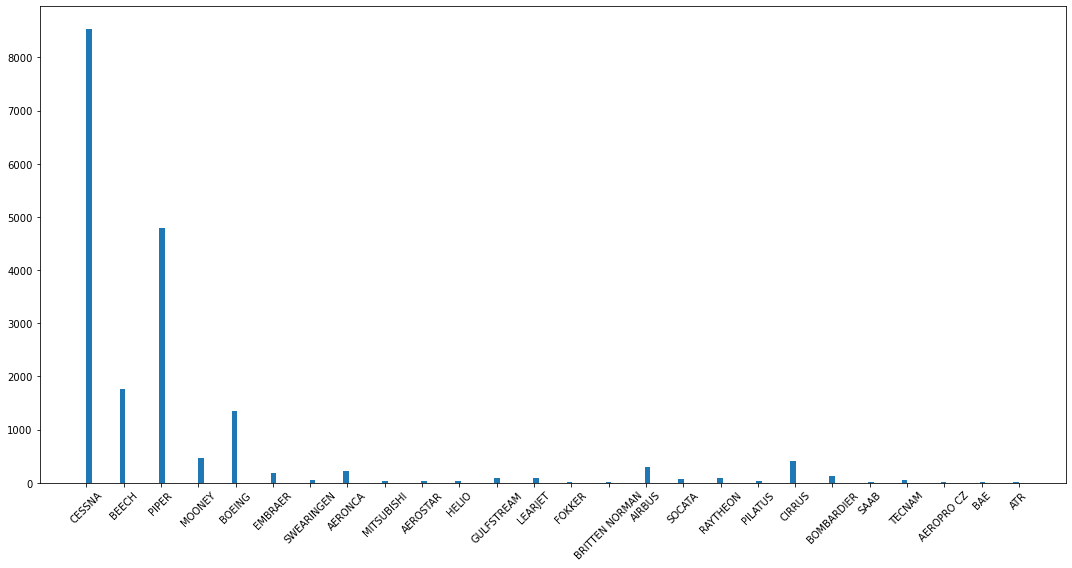

In [41]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(rlm_df['Make'], bins='auto')
plt.xticks(rotation=45)
plt.tight_layout();

This tells us who the stakeholder may purchase aircraft from, but on a widely varied scale of airliners that hold hundreds of passengers to light aircraft that can seat just a few people. 

However, it won't tell us who has the best overall reputation for safety until we know how to measure these incidents against how big these manufacturers are. Specifically, I think we'll need a dictionary with each manufacturer as the key and the amount of aircraft they've made as the value. Only then will we be able to show the percentage of aircraft involved in incidents to the total aircraft ever made. 

Before we bring in a lot of extra data, let's reconsider what else the dataset already shows us. There may be other criteria to keep in mind when it comes to low-risk aircraft besides the manufacturer-oriented path we're heading down right now. 

In [42]:
#Updating the filtered_df to only include the relevant manufacturers and its more relevant columns:
filtered_df = rlm_df[['Make', 'Model', 'Aircraft.damage', 'Number.of.Engines', 'Total.Fatal.Injuries', \
                      'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', 'Publication.Date']]
filtered_df.head()

,Make,Model,Aircraft.damage,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Publication.Date
7,CESSNA,140,Substantial,1.0,0.0,0.0,0.0,2.0,01-01-1982
8,CESSNA,401B,Substantial,2.0,0.0,0.0,0.0,2.0,01-01-1982
13,CESSNA,R172K,Destroyed,1.0,1.0,0.0,0.0,0.0,02-01-1983
15,BEECH,19,Destroyed,1.0,2.0,0.0,0.0,0.0,02-01-1983
17,CESSNA,180,Destroyed,1.0,3.0,0.0,0.0,0.0,02-01-1983


In order to gain insight into our dataset's correlations, let's transform our categorical columns into numerical ones before constructing a correlation matrix:

In [43]:
filtered_df['Aircraft.damage'].value_counts()

Substantial    14291
Destroyed       2465
Minor            787
Name: Aircraft.damage, dtype: int64

In [44]:
dummies = pd.get_dummies(filtered_df['Aircraft.damage']).rename(columns=lambda x: 'Aircraft.damage_' + str(x))
filtered_df = pd.concat([filtered_df, dummies], axis=1)
filtered_df = filtered_df.drop(['Aircraft.damage'], axis=1)

In [45]:
filtered_df

,Make,Model,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Publication.Date,Aircraft.damage_Destroyed,Aircraft.damage_Minor,Aircraft.damage_Substantial
7,CESSNA,140,1.0,0.0,0.0,0.0,2.0,01-01-1982,0,0,1
8,CESSNA,401B,2.0,0.0,0.0,0.0,2.0,01-01-1982,0,0,1
13,CESSNA,R172K,1.0,1.0,0.0,0.0,0.0,02-01-1983,1,0,0
15,BEECH,19,1.0,2.0,0.0,0.0,0.0,02-01-1983,1,0,0
17,CESSNA,180,1.0,3.0,0.0,0.0,0.0,02-01-1983,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
88865,CESSNA,172,1.0,0.0,0.0,0.0,1.0,15-12-2022,0,0,1
88869,PIPER,PA42,2.0,0.0,0.0,0.0,1.0,14-12-2022,0,0,1
88873,CIRRUS,SR22,1.0,0.0,0.0,0.0,1.0,27-12-2022,0,0,1
88876,SWEARINGEN,SA226TC,2.0,0.0,0.0,0.0,1.0,19-12-2022,0,0,1


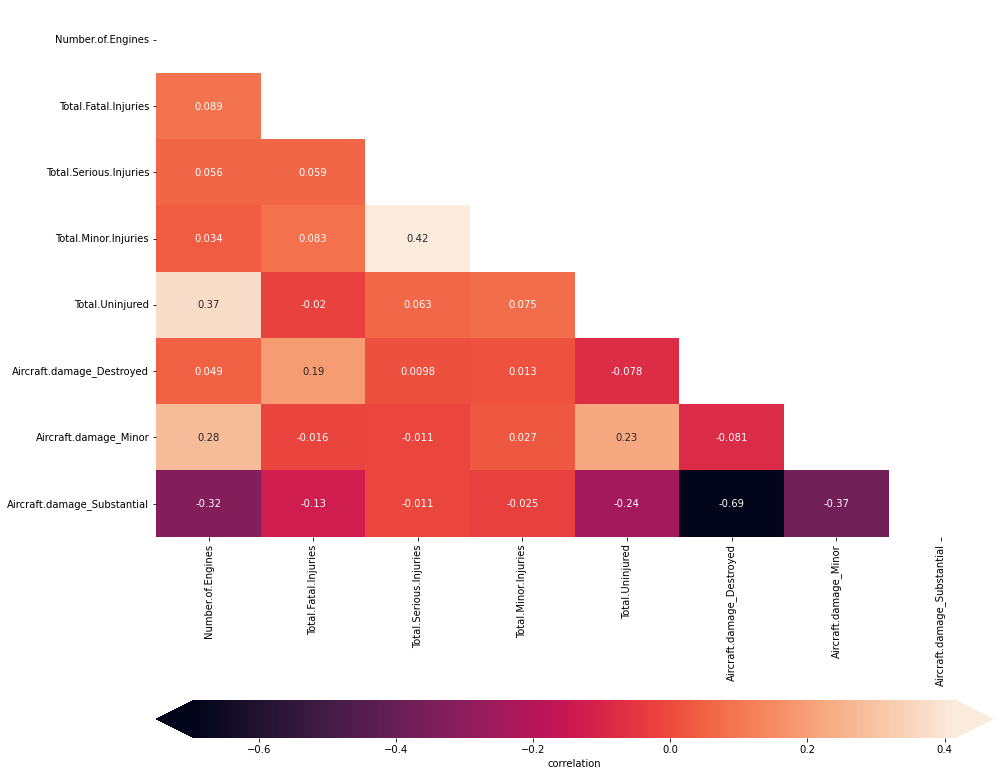

In [46]:
#Making the correlation matrix:
import seaborn as sns
heatmap_data = filtered_df
corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=corr, mask=np.triu(corr), ax=ax, annot=True, 
            cbar_kws={'label':'correlation', 'orientation':'horizontal', 'pad':.2, 'extend':'both'});

## Interpreting the correlation heat map and finalizing the project goals and methods

The strongest relevant corellation is a negative one: the more engines a plane has, the more uninjured people there are in an accident. This makes sense since larger aircraft have more engines and carry more people, but let's see what other, more specific insight we can find here:

In [47]:
filtered_df['Number.of.Engines'].value_counts()

1.0    13571
2.0     3066
4.0       76
3.0       18
0.0        5
Name: Number.of.Engines, dtype: int64

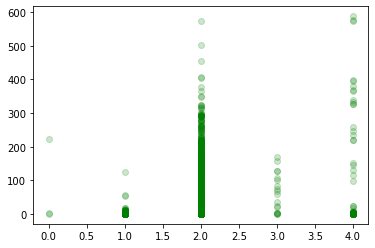

In [48]:
fig, ax = plt.subplots()
ax.scatter(filtered_df['Number.of.Engines'], filtered_df['Total.Uninjured'], color='g', alpha=0.2);

As one may gather from the above graph, we (1) have planes with no engines here (we'll drop those NaNs) and (2) probably an assimilation of aircraft with one, two, or four engines with a few three-engined planes, (3) bigger planes can probably take on tough weather conditions better than some tiny aluminum can with wings and (4) they takeoff & land on actual runways all the time, not some patch of gravel in the boonies. Also, (5) I wonder whether there are more light, single-engine aircraft than bigger ones with 2+ engines?

However, with those cautionary observations in mind, it *does* look like more people live or escape uninjured in incidents involving planes with more engines.

### What else does our dataset show well? What more should we look into before deciding on a goal for our three business recommendations?

Injuries: they're seperated into minor, serious, and fatal. I wonder to what extent the stakeholder wants to know about  minor vs. serious injuries as opposed to injuries in general (any injury is bad). I also wonder whether they'll want to discern between injuires vs. fatalities if they just want the "lowest-risk" aircraft *and* I don't want to overwhelm them with data. 

To that end, I'll combine all injuries (later, maybe even combining them with fatalities). 

In [49]:
#Combining the injury columns
filtered_df['Total.Injuries'] = filtered_df['Total.Serious.Injuries'] + filtered_df['Total.Minor.Injuries']

In [50]:
#Dropping the two constituent ones:
filtered_df.drop(['Total.Serious.Injuries', 'Total.Minor.Injuries'], axis=1, inplace=True)

In [51]:
#Renaming fatal injury column for clarity:
filtered_df.rename(columns={'Total.Fatal.Injuries':'Total.Fatalities'}, inplace=True)
filtered_df.head()

,Make,Model,Number.of.Engines,Total.Fatalities,Total.Uninjured,Publication.Date,Aircraft.damage_Destroyed,Aircraft.damage_Minor,Aircraft.damage_Substantial,Total.Injuries
7,CESSNA,140,1.0,0.0,2.0,01-01-1982,0,0,1,0.0
8,CESSNA,401B,2.0,0.0,2.0,01-01-1982,0,0,1,0.0
13,CESSNA,R172K,1.0,1.0,0.0,02-01-1983,1,0,0,0.0
15,BEECH,19,1.0,2.0,0.0,02-01-1983,1,0,0,0.0
17,CESSNA,180,1.0,3.0,0.0,02-01-1983,1,0,0,0.0


Let's examine how manufacturers break down with fatality and injury counts now:

In [52]:
fatalities_by_mnfr = filtered_df.groupby('Make')['Total.Fatalities'].sum().sort_values()
fatalities_by_mnfr

Make
BAE              1.0
AEROPRO CZ       2.0
SAAB             2.0
HELIO            5.0
TECNAM           6.0
               ...  
BEECH         1274.0
AIRBUS        1668.0
PIPER         1948.0
CESSNA        3106.0
BOEING        3282.0
Name: Total.Fatalities, Length: 26, dtype: float64

Now let's produce a few visualizations to see how our original citerion (manufacturer) looks in terms of these fatalities, injuires, and enginer quantities:

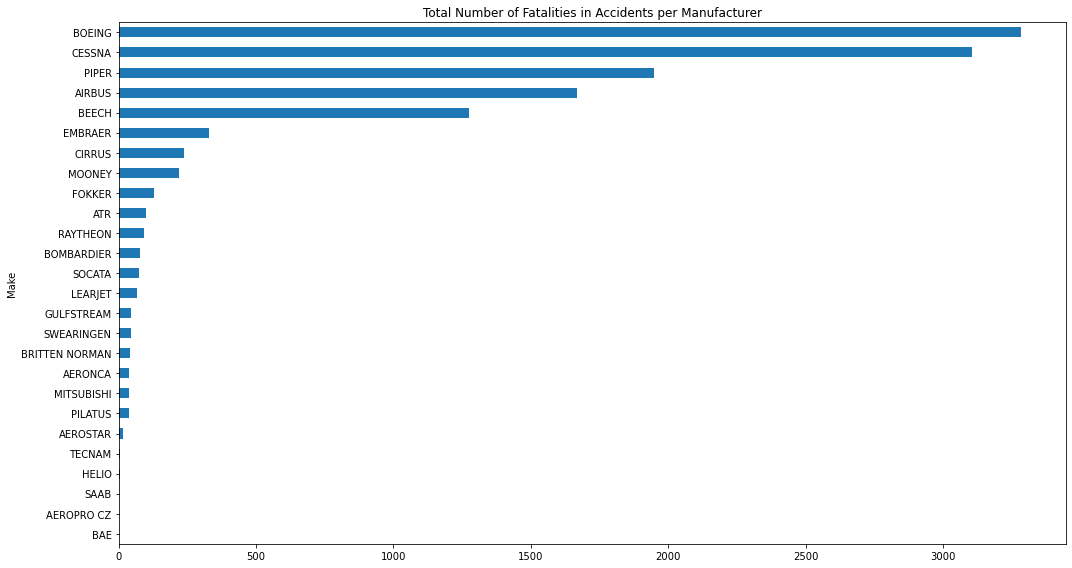

In [53]:
fatalities_by_mnfr.plot.barh(figsize=(15,8))
plt.title('Total Number of Fatalities in Accidents per Manufacturer')
plt.tight_layout();

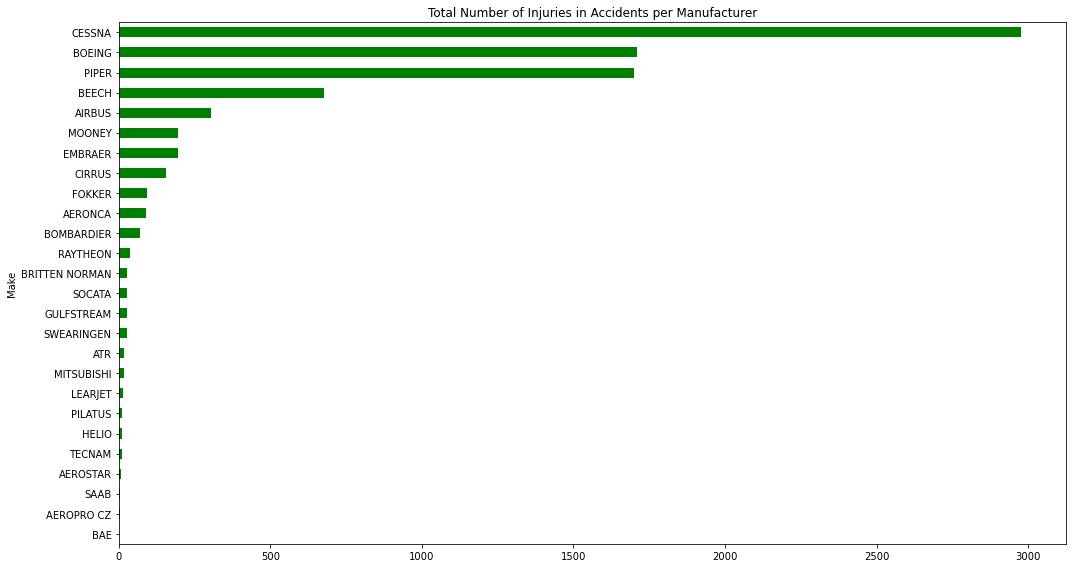

In [54]:
injuries_by_mnfr = filtered_df.groupby('Make')['Total.Injuries'].sum().sort_values()
injuries_by_mnfr.plot.barh(color='g', figsize=(15,8))
plt.title('Total Number of Injuries in Accidents per Manufacturer')
plt.tight_layout();

Let's continue with this more focused EDA avenue by doing the same thing with number of engines: 

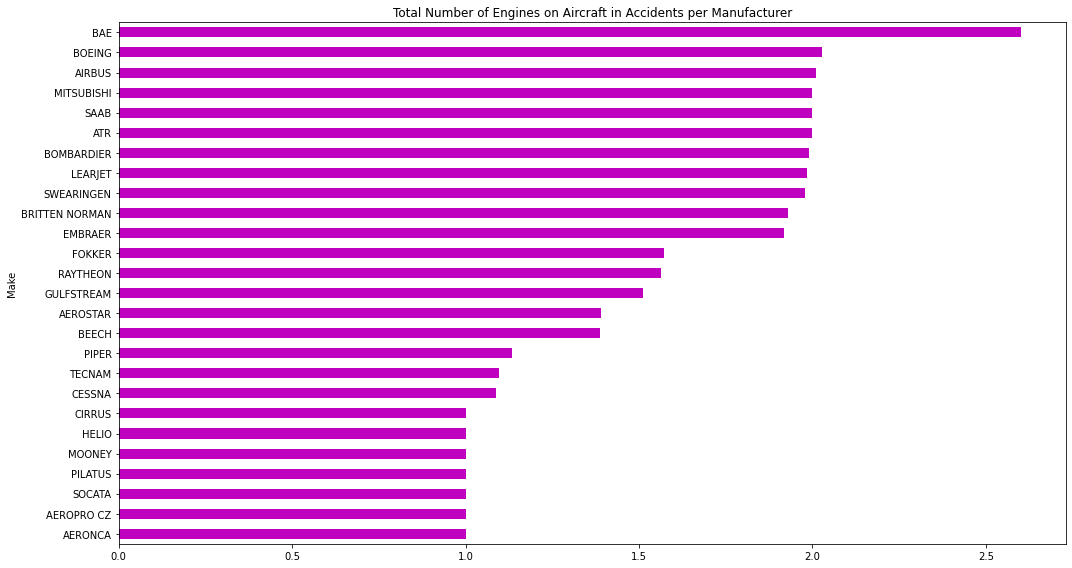

In [55]:
avg_num_engines_by_mnfr = filtered_df.groupby('Make')['Number.of.Engines'].mean().sort_values()
avg_num_engines_by_mnfr.plot.barh(color='m', figsize=(15,8))
plt.title('Total Number of Engines on Aircraft in Accidents per Manufacturer')
plt.tight_layout();

It looks like these large manufacturers that produce smaller planes have a lot of injuries and fatalities when you consider how small the planes are. I think this shows that light aircraft are definitely riskier than even somewhat larger planes (like private jets and anything larger). I think this may show that, if we're interested in lower-risk aircraft, this light (as in single-engine) category may need to be eliminated. 

These visualizations help us see who makes the bigger/multi-engine planes and who makes the light aircraft (besides Piper & Cessna). Let's do a bar chart showing each manufacturer on the x-axis and then the fatalities and injuries next to it.

In [56]:
#fig, ax = plt.subplots()
#ax.bar(x=filtered_df["Make"], y=[filtered_df["Number.of.Engines"], filtered_df["Total.Injuries"], filtered_df["Total.Fatalities"]], rot=0);
#filtered_df.plot(x='Make', y=['Number.of.Engines', 'Total.Injuries', 'Total.Fatalities'], kind='bar');

to_bar_graph = filtered_df.groupby('Make').agg({'Number.of.Engines':'mean',\
                                                'Total.Injuries':'mean',\
                                                'Total.Fatalities':'mean'})

to_bar_graph.rename(columns={'Number.of.Engines': 'average.number.of.engines', \
                             'Total.Injuries':'average.injuries.per.incident', 
                             'Total.Fatalities':'average.fatalities.per.incident'},
                               inplace=True)

to_bar_graph

,average.number.of.engines,average.injuries.per.incident,average.fatalities.per.incident
Make,,,
AERONCA,1.000000,0.451777,0.197970
AEROPRO CZ,1.000000,0.250000,0.166667
AEROSTAR,1.391304,0.562500,0.941176
AIRBUS,2.010363,1.133829,6.200743
ATR,2.000000,1.000000,5.941176
...,...,...,...
RAYTHEON,1.564103,0.444444,1.120482
SAAB,2.000000,0.333333,0.166667
SOCATA,1.000000,0.383562,0.973333


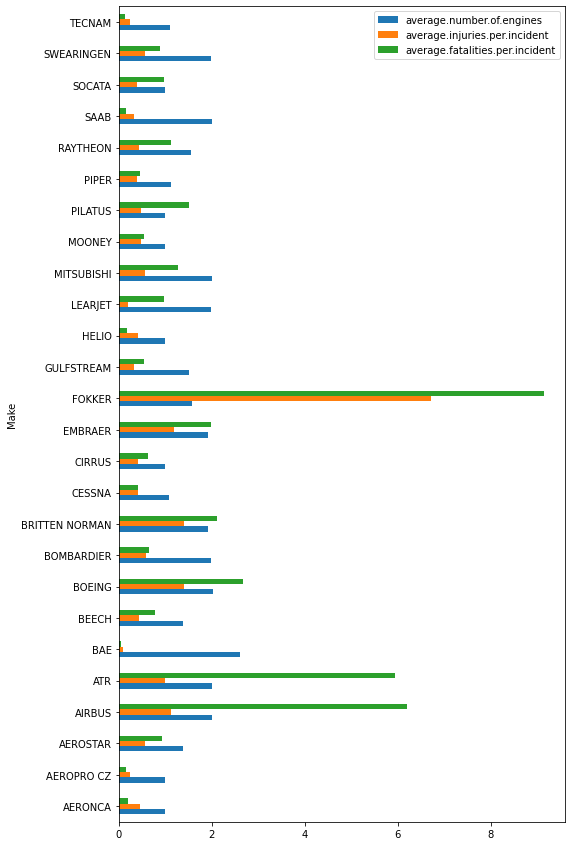

In [57]:
to_bar_graph.plot(kind='barh', figsize=(8,15));

Good Lord, *what* is goin' on at Fokker? Anyway, this might be going somewhere (at least *somewhat*) insightful. However, there's still too much info on display here; let's combine fatalities & injuries just to see:

In [58]:
simpler_bar_graph = filtered_df[['Make', 'Total.Injuries', 'Total.Fatalities', 'Number.of.Engines']]
simpler_bar_graph['Total.Injuries.and.Fatalities'] = filtered_df['Total.Injuries'] + filtered_df['Total.Fatalities']
simpler_bar_graph.drop(['Total.Injuries', 'Total.Fatalities'], axis=1, inplace=True)
simpler_bar_graph

,Make,Number.of.Engines,Total.Injuries.and.Fatalities
7,CESSNA,1.0,0.0
8,CESSNA,2.0,0.0
13,CESSNA,1.0,1.0
15,BEECH,1.0,2.0
17,CESSNA,1.0,3.0
...,...,...,...
88865,CESSNA,1.0,0.0
88869,PIPER,2.0,0.0
88873,CIRRUS,1.0,0.0
88876,SWEARINGEN,2.0,0.0


In [59]:
simpler_bar_graph = simpler_bar_graph.groupby('Make').agg(\
                                                          {'Number.of.Engines':'mean', \
                                                           'Total.Injuries.and.Fatalities':'mean'})

simpler_bar_graph.rename(columns={'Number.of.Engines': 'average.number.of.engines', \
                                    'Total.Injuries.and.Fatalities':'average.injuries.and.fatalities.per.incident'},
                                    inplace=True)

simpler_bar_graph.sort_values(['average.injuries.and.fatalities.per.incident'], inplace=True)

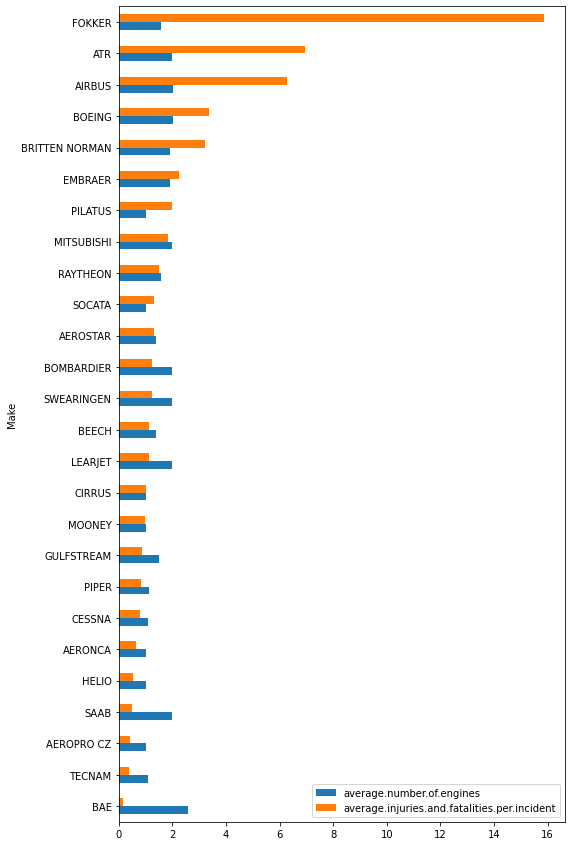

In [60]:
simpler_bar_graph.plot(kind='barh', figsize=(8,15));

It looks like if you want 2+ engines (that means lower-risk) and then those plane manufacturers' best safety records, then you want a plane made by Embrear, Raytheon, Mitsubishi, Bombadier, Swearingen, maybe Beechcraft or Gulfstream (not as many 2+ enginer aircraft overall), Learjet, SAAB, or BAE.

However, those are all regional and private jet manufacturers. If our stakeholder is interested in larger airliners, it looks like Boeing is safer than Airbus. 

This is a limited perspective, though. I still haven't looked into the different models among these makes. I'm also almost certainly not comparing apples-to-apples when it comes to how many planes these manufacturers have made or how long they've been around. In other words, an older & larger company would have a lot more flight time against which to measure each accident.

When it comes to incorporating plane models and not just makes into the picture, that should be do-able if we start to narrow down the manufacturers involved. I think we may have license to do so based on the above graph. We can even seperate them into private, regional, and large airliner tiers. This terminology isn't FAA-official, but it just seperates the little private aircraft (around 5-10 million USD) from the regional airliners that have 100 or fewer seats (around 45 million USD) from the larger, longer-hauling airliners (more than 100 seats and usually hundreds of millions of dollars). 

**This could inform three business recommendations:** (1) which type of aircraft are safest (including the number-of-engines correlation, thereby justifying the private/regional/larger tiers and likely omitting light aircraft), then (2) makes per tier, and finally (3) models per tier.

Our next step will be to furhter investigate the role of the engine count in accident severity a little further:

In [61]:
filtered_df['Number.of.Engines'].value_counts()

1.0    13571
2.0     3066
4.0       76
3.0       18
0.0        5
Name: Number.of.Engines, dtype: int64

In [62]:
#Why are there zero-engine planes here?
filtered_df.loc[filtered_df['Number.of.Engines'] == 0]

,Make,Model,Number.of.Engines,Total.Fatalities,Total.Uninjured,Publication.Date,Aircraft.damage_Destroyed,Aircraft.damage_Minor,Aircraft.damage_Substantial,Total.Injuries
19931,PIPER,PA-38,0.0,1.0,NaN,NaN,1,0,0,NaN
21901,AIRBUS,A-300B4-203,0.0,NaN,222.0,06-02-1995,0,0,0,5.0
27319,PIPER,PA-34,0.0,NaN,1.0,31-01-2018,0,0,1,NaN
29591,BOEING,B-747-121,0.0,NaN,NaN,05-08-1996,0,1,0,NaN
32014,PIPER,PA-34-200,0.0,NaN,2.0,05-08-1996,0,0,1,NaN


The five records where the number of engines are listed as zero have other NaNs throughout, so we can drop them since there are so few.

In [63]:
filtered_df = filtered_df[filtered_df['Number.of.Engines'] != 0]

Since the primary concern involves lower risk overall, I'll combine the injury & fatality columns for now. Both are bad, so let's see how everything stacks up when it comes to both.

In [64]:
#Let's look at the total number of injuries and fatalities per engine count:
filtered_df['total.inj.or.killed'] = filtered_df['Total.Injuries']+filtered_df['Total.Fatalities']
injuries_and_fatalities_by_engine_count = filtered_df.groupby('Number.of.Engines')['total.inj.or.killed'].sum()
injuries_and_fatalities_by_engine_count

Number.of.Engines
1.0    8749.0
2.0    4822.0
3.0      91.0
4.0      90.0
Name: total.inj.or.killed, dtype: float64

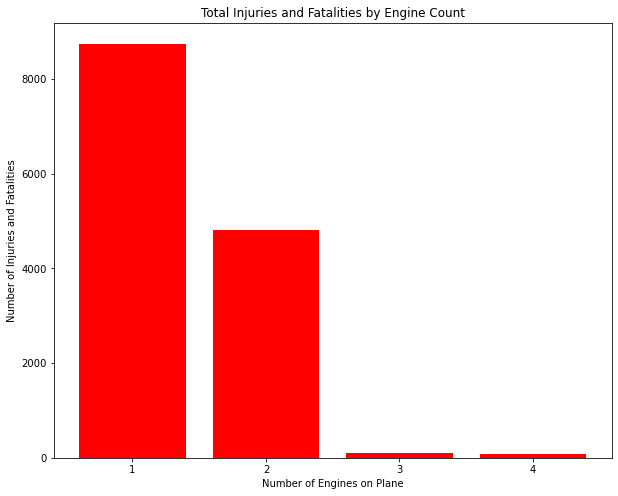

In [65]:
from matplotlib.ticker import MaxNLocator
#source: https://stackoverflow.com/questions/12050393/how-to-force-the-y-axis-to-only-use-integers
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(injuries_and_fatalities_by_engine_count.index, injuries_and_fatalities_by_engine_count.values, color='r')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of Engines on Plane')
ax.set_ylabel('Number of Injuries and Fatalities')
ax.set_title('Total Injuries and Fatalities by Engine Count')
plt.tight_layout;

In [66]:
#Let's also examine incidents per engine count:
incidents_by_engine_count = filtered_df['Number.of.Engines'].value_counts().sort_values(ascending=False)
incidents_by_engine_count

1.0    13571
2.0     3066
4.0       76
3.0       18
Name: Number.of.Engines, dtype: int64

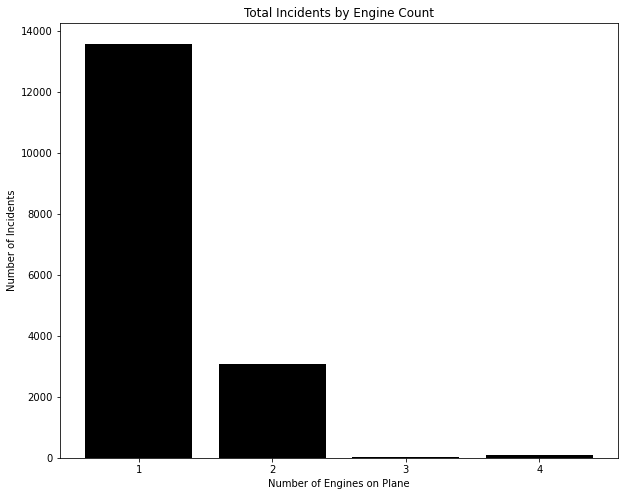

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(incidents_by_engine_count.index, incidents_by_engine_count.values, color='k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Number of Engines on Plane')
ax.set_ylabel('Number of Incidents')
ax.set_title('Total Incidents by Engine Count')
plt.tight_layout;

Multi-engined planes are substantially lower-risk, *especially* when you consider the injuries and fatalities graph and how these single-engine planes carry fewer people. Subsequently, the first recommendation I would make would be to only consider aircraft with two or more engines. Let's continue to focus on just those aircraft for our stakeholder.

In [68]:
#Dropping single-engine planes
filtered_df = filtered_df[filtered_df['Number.of.Engines'] > 1]

## Handling NaN's

Before we start to make more insightful visualizations or ultimate recommendation decisions, let's see if anything else needs to happen with our filtered_df in terms of NaN's.

In [69]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3160 entries, 8 to 88876
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Make                         3160 non-null   object 
 1   Model                        3155 non-null   object 
 2   Number.of.Engines            3160 non-null   float64
 3   Total.Fatalities             2911 non-null   float64
 4   Total.Uninjured              3076 non-null   float64
 5   Publication.Date             3049 non-null   object 
 6   Aircraft.damage_Destroyed    3160 non-null   uint8  
 7   Aircraft.damage_Minor        3160 non-null   uint8  
 8   Aircraft.damage_Substantial  3160 non-null   uint8  
 9   Total.Injuries               2860 non-null   float64
 10  total.inj.or.killed          2853 non-null   float64
dtypes: float64(5), object(3), uint8(3)
memory usage: 231.4+ KB


The only NaNs I'm still concerned with are 'Total.Fatalities' and 'Total.Injuries'; they're pretty crucial when it comes to determining risk. 

These don't seem like NaNs I can impute. Does NaN maybe mean 0 here? Unfortunately, not always. After looking up some of these incidents, there are definitely some rows with NaNs in the fatalities column where there were none, but I found an entry where there were fatalities (in the cell above, it's index 14357 from August 2011, shown here: https://aviation-safety.net/wikibase/137908).

If I drop all these NaNs, I'll go from 3,155 records to 2,850 (losing 9% of the data). This isn't *too* bad a loss since going through 305 records to fill the NaNs is time-prohibitive. 

In [70]:
filtered_df = filtered_df.dropna(subset=['Total.Fatalities', 'Total.Injuries'])
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2853 entries, 8 to 88876
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Make                         2853 non-null   object 
 1   Model                        2850 non-null   object 
 2   Number.of.Engines            2853 non-null   float64
 3   Total.Fatalities             2853 non-null   float64
 4   Total.Uninjured              2853 non-null   float64
 5   Publication.Date             2748 non-null   object 
 6   Aircraft.damage_Destroyed    2853 non-null   uint8  
 7   Aircraft.damage_Minor        2853 non-null   uint8  
 8   Aircraft.damage_Substantial  2853 non-null   uint8  
 9   Total.Injuries               2853 non-null   float64
 10  total.inj.or.killed          2853 non-null   float64
dtypes: float64(5), object(3), uint8(3)
memory usage: 209.0+ KB


In [71]:
filtered_df[filtered_df.isna().any(axis=1)]

,Make,Model,Number.of.Engines,Total.Fatalities,Total.Uninjured,Publication.Date,Aircraft.damage_Destroyed,Aircraft.damage_Minor,Aircraft.damage_Substantial,Total.Injuries,total.inj.or.killed
65583,BEECH,65A90,2.0,3.0,0.0,NaN,0,0,0,0.0,3.0
65618,BOEING,NaN,2.0,0.0,0.0,03-11-2020,0,0,1,0.0,0.0
66841,BOEING,NaN,2.0,0.0,0.0,03-11-2020,0,1,0,0.0,0.0
67690,BOEING,747,4.0,0.0,0.0,NaN,0,1,0,0.0,0.0
68862,BOEING,747-44AF,4.0,2.0,0.0,NaN,1,0,0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
88118,AIRBUS,A320,2.0,0.0,0.0,NaN,0,0,0,0.0,0.0
88129,BEECH,400A,2.0,0.0,0.0,NaN,0,0,0,0.0,0.0
88456,BOEING,777-222,2.0,0.0,0.0,NaN,0,0,0,0.0,0.0
88665,BOEING,787-9,2.0,0.0,0.0,NaN,0,1,0,0.0,0.0


In [72]:
filtered_df = filtered_df.dropna(subset=['Model'])
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850 entries, 8 to 88876
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Make                         2850 non-null   object 
 1   Model                        2850 non-null   object 
 2   Number.of.Engines            2850 non-null   float64
 3   Total.Fatalities             2850 non-null   float64
 4   Total.Uninjured              2850 non-null   float64
 5   Publication.Date             2745 non-null   object 
 6   Aircraft.damage_Destroyed    2850 non-null   uint8  
 7   Aircraft.damage_Minor        2850 non-null   uint8  
 8   Aircraft.damage_Substantial  2850 non-null   uint8  
 9   Total.Injuries               2850 non-null   float64
 10  total.inj.or.killed          2850 non-null   float64
dtypes: float64(5), object(3), uint8(3)
memory usage: 208.7+ KB


## Cleaning the 'Model' column
Similar to the 'Make' column, a lot of duplications exist among plane model names. Some planes underwent slight revisions that do not constitute a whole new category for our purposes, others are simply different ways of spelling out a model name. Doing some Googling alongside checking values helped construct the model cleaning seen below:

In [73]:
#Standardizing the Boeing plane models
filtered_df.loc[filtered_df['Model'].str.contains('707'), 'Model'] = '707'
filtered_df.loc[filtered_df['Model'].str.contains('717'), 'Model'] = '717'
filtered_df.loc[filtered_df['Model'].str.contains('727'), 'Model'] = '727'
filtered_df.loc[filtered_df['Model'].str.contains('737'), 'Model'] = '737'
filtered_df.loc[filtered_df['Model'].str.contains('747'), 'Model'] = '747'
filtered_df.loc[filtered_df['Model'].str.contains('757'), 'Model'] = '757'
filtered_df.loc[filtered_df['Model'].str.contains('767'), 'Model'] = '767'
filtered_df.loc[filtered_df['Model'].str.contains('777'), 'Model'] = '777'
filtered_df.loc[filtered_df['Model'].str.contains('787'), 'Model'] = '787'

In [74]:
#Piper
filtered_df.loc[filtered_df['Model'].str.contains('23'), 'Model'] = 'PA-23'
filtered_df.loc[filtered_df['Model'].str.contains('PA23'), 'Model'] = 'PA-23'
filtered_df.loc[filtered_df['Model'].str.contains('PA 23'), 'Model'] = 'PA-23'
filtered_df.loc[filtered_df['Model'].str.contains('PA-23'), 'Model'] = 'PA-23'
filtered_df.loc[filtered_df['Model'].str.contains('PA-28'), 'Model'] = 'PA-28'
filtered_df.loc[filtered_df['Model'].str.contains('PA28'), 'Model'] = 'PA-28'
filtered_df.loc[filtered_df['Model'].str.contains('PA 28'), 'Model'] = 'PA-28'
filtered_df.loc[filtered_df['Model'].str.contains('PA30'), 'Model'] = 'PA-30'
filtered_df.loc[filtered_df['Model'].str.contains('PA-30'), 'Model'] = 'PA-30'
filtered_df.loc[filtered_df['Model'].str.contains('PA 30'), 'Model'] = 'PA-30'
filtered_df.loc[filtered_df['Model'].str.contains('PA31'), 'Model'] = 'PA-31'
filtered_df.loc[filtered_df['Model'].str.contains('PA 31'), 'Model'] = 'PA-31'
filtered_df.loc[filtered_df['Model'].str.contains('PA-31'), 'Model'] = 'PA-31'
filtered_df.loc[filtered_df['Model'].str.contains('PA-32'), 'Model'] = 'PA-32'
filtered_df.loc[filtered_df['Model'].str.contains('PA-34'), 'Model'] = 'PA-34'
filtered_df.loc[filtered_df['Model'].str.contains('PA 34'), 'Model'] = 'PA-34'
filtered_df.loc[filtered_df['Model'].str.contains('PA34'), 'Model'] = 'PA-34'
filtered_df.loc[filtered_df['Model'].str.contains('PA-38'), 'Model'] = 'PA-38'
filtered_df.loc[filtered_df['Model'].str.contains('PA-42'), 'Model'] = 'PA-42'
filtered_df.loc[filtered_df['Model'].str.contains('PA42'), 'Model'] = 'PA-42'
filtered_df.loc[filtered_df['Model'].str.contains('PA-44'), 'Model'] = 'PA-44'
filtered_df.loc[filtered_df['Model'].str.contains('PA44'), 'Model'] = 'PA-44'
filtered_df.loc[filtered_df['Model'].str.contains('PA 44'), 'Model'] = 'PA-44'
filtered_df.loc[filtered_df['Model'].str.contains('PA-60'), 'Model'] = 'PA-60'
filtered_df.loc[filtered_df['Model'].str.contains('PA60'), 'Model'] = 'PA-60'

In [75]:
#Airbus
filtered_df.loc[filtered_df['Model'].str.contains('A300'), 'Model'] = 'A300'
filtered_df.loc[filtered_df['Model'].str.contains('F4-622R'), 'Model'] = 'A300'
filtered_df.loc[filtered_df['Model'].str.contains('A319'), 'Model'] = 'A319'
filtered_df.loc[filtered_df['Model'].str.contains('A-320'), 'Model'] = 'A320'
filtered_df.loc[filtered_df['Model'].str.contains('330'), 'Model'] = 'A330'
filtered_df.loc[filtered_df['Model'].str.contains('A320'), 'Model'] = 'A320'
filtered_df.loc[filtered_df['Model'].str.contains('321'), 'Model'] = 'A321'
filtered_df.loc[filtered_df['Model'].str.contains('A321'), 'Model'] = 'A321'
filtered_df.loc[filtered_df['Model'].str.contains('340'), 'Model'] = '340'

In [76]:
#Cessna
filtered_df.loc[filtered_df['Model'] == '150F', 'Model'] = '150'
filtered_df.loc[filtered_df['Model'].str.contains('337'), 'Model'] = 'Skymaster'
filtered_df.loc[filtered_df['Model'].str.contains('414'), 'Model'] = '414'
filtered_df.loc[filtered_df['Model'].str.contains('Citation'), 'Model'] = 'Citation'
filtered_df.loc[filtered_df['Model'].str.contains('501'), 'Model'] = 'Citation'
filtered_df.loc[filtered_df['Model'].str.contains('505'), 'Model'] = 'Citation'
filtered_df.loc[filtered_df['Model'].str.contains('510'), 'Model'] = 'Citation'
filtered_df.loc[filtered_df['Model'].str.contains('525'), 'Model'] = 'Citation'

In [77]:
#Embraer
filtered_df.loc[filtered_df['Model'].str.contains('ERJ 190'), 'Model'] = 'EMB190'
filtered_df.loc[filtered_df['Model'].str.contains('ERJ190'), 'Model'] = 'EMB190'
filtered_df.loc[filtered_df['Model'].str.contains('E190'), 'Model'] = 'EMB190'
filtered_df.loc[filtered_df['Model'].str.contains('E 90'), 'Model'] = 'EMB190'
filtered_df.loc[filtered_df['Model'].str.contains('ERJ 170'), 'Model'] = 'EMB170'
filtered_df.loc[filtered_df['Model'].str.contains('ERJ170'), 'Model'] = 'EMB170'
filtered_df.loc[filtered_df['Model'].str.contains('E170'), 'Model'] = 'EMB170'
filtered_df.loc[filtered_df['Model'].str.contains('ERJ-145'), 'Model'] = 'EMB145'
filtered_df.loc[filtered_df['Model'].str.contains('ERJ175'), 'Model'] = 'EMB175'
filtered_df.loc[filtered_df['Model'].str.contains('E175'), 'Model'] = 'EMB175'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-11O'), 'Model'] = 'EMB110'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-110'), 'Model'] = 'EMB110'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-120'), 'Model'] = 'EMB120'
filtered_df.loc[filtered_df['Model'].str.contains('EMB 120'), 'Model'] = 'EMB120'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-135'), 'Model'] = 'EMB135'
filtered_df.loc[filtered_df['Model'].str.contains('EMB 135'), 'Model'] = 'EMB135'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-145'), 'Model'] = 'EMB145'
filtered_df.loc[filtered_df['Model'].str.contains('EMB 145'), 'Model'] = 'EMB145'
filtered_df.loc[filtered_df['Model'].str.contains('EMB145'), 'Model'] = 'EMB145'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-170'), 'Model'] = 'EMB170'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-190'), 'Model'] = 'EMB190'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-500'), 'Model'] = 'EMB500'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-545'), 'Model'] = 'EMB545'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-550'), 'Model'] = 'EMB550'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-810'), 'Model'] = 'EMB810'
filtered_df.loc[filtered_df['Model'].str.contains('EMB-820'), 'Model'] = 'EMB820'

In [78]:
#Saab
filtered_df.loc[filtered_df['Model'].str.contains('SA 226'), 'Model'] = 'SA226'
filtered_df.loc[filtered_df['Model'].str.contains('SA226'), 'Model'] = 'SA226'
filtered_df.loc[filtered_df['Model'].str.contains('SA-226'), 'Model'] = 'SA226'
filtered_df.loc[filtered_df['Model'].str.contains('SA26'), 'Model'] = 'SA226'
filtered_df.loc[filtered_df['Model'].str.contains('SA227'), 'Model'] = 'SA227'
filtered_df.loc[filtered_df['Model'].str.contains('SA-227'), 'Model'] = 'SA227'
filtered_df.loc[filtered_df['Model'].str.contains('SAAB 2000'), 'Model'] = '2000'

In [79]:
#Beech
filtered_df.loc[filtered_df['Model'].str.contains('A55'), 'Model'] = 'A55'
filtered_df.loc[filtered_df['Model'].str.contains('A90'), 'Model'] = '65-A90'
filtered_df.loc[filtered_df['Model'].str.contains('B 55'), 'Model'] = 'B55'
filtered_df.loc[filtered_df['Model'].str.contains('B55'), 'Model'] = 'B55'
filtered_df.loc[filtered_df['Model'].str.contains('B-55'), 'Model'] = 'B55'
filtered_df.loc[filtered_df['Model'].str.contains('B 60'), 'Model'] = 'B60'
filtered_df.loc[filtered_df['Model'].str.contains('B99'), 'Model'] = 'B99'
filtered_df.loc[filtered_df['Model'].str.contains('BE99'), 'Model'] = 'B99'
filtered_df.loc[filtered_df['Model'].str.contains('B-99'), 'Model'] = 'B99'
filtered_df.loc[filtered_df['Model'].str.contains('B-99'), 'Model'] = 'B99'
filtered_df.loc[filtered_df['Model'].str.contains('C 99'), 'Model'] = 'C99'
filtered_df.loc[filtered_df['Model'].str.contains('C45'), 'Model'] = 'C45'
filtered_df.loc[filtered_df['Model'].str.contains('C-45'), 'Model'] = 'C45'
filtered_df.loc[filtered_df['Model'].str.contains('C-50'), 'Model'] = 'C50'
filtered_df.loc[filtered_df['Model'].str.contains('C 50'), 'Model'] = 'C50'
filtered_df.loc[filtered_df['Model'].str.contains('C55'), 'Model'] = 'C55'
filtered_df.loc[filtered_df['Model'].str.contains('E-55'), 'Model'] = 'E55'
filtered_df.loc[filtered_df['Model'].str.contains('E-90'), 'Model'] = 'E90'
filtered_df.loc[filtered_df['Model'].str.contains('95 55'), 'Model'] = 'B55'
filtered_df.loc[filtered_df['Model'].str.contains('95-55'), 'Model'] = 'B55'
filtered_df.loc[filtered_df['Model'].str.contains('95-B55'), 'Model'] = 'B55'
filtered_df.loc[filtered_df['Model'].str.contains('95B55'), 'Model'] = 'B55'
filtered_df.loc[filtered_df['Model'].str.contains('C90'), 'Model'] = 'C90'
filtered_df.loc[filtered_df['Model'].str.contains('C 90'), 'Model'] = 'C90'
filtered_df.loc[filtered_df['Model'].str.contains('C-90'), 'Model'] = 'C90'
filtered_df.loc[filtered_df['Model'].str.contains('C99'), 'Model'] = 'C99'
filtered_df.loc[filtered_df['Model'].str.contains('G-58'), 'Model'] = 'G58'
filtered_df.loc[filtered_df['Model'] == '350', 'Model'] = 'B300'
filtered_df.loc[filtered_df['Model'].str.contains('900'), 'Model'] = '1900'
filtered_df.loc[filtered_df['Model'].str.contains('1900'), 'Model'] = '1900'
#Gulfstream
filtered_df.loc[filtered_df['Model'].str.contains('GIV'), 'Model'] = 'GIV'
filtered_df.loc[filtered_df['Model'].str.contains('G IV'), 'Model'] = 'GIV'
filtered_df.loc[filtered_df['Model'].str.contains('G-IV'), 'Model'] = 'GIV'
filtered_df.loc[filtered_df['Model'].str.contains('GULFSTREAM150'), 'Model'] = 'G150'
filtered_df.loc[filtered_df['Model'].str.contains('G150'), 'Model'] = 'G150'
filtered_df.loc[filtered_df['Model'].str.contains('G159'), 'Model'] = 'G-159C'
filtered_df.loc[filtered_df['Model'].str.contains('G-159'), 'Model'] = 'G-159C'
filtered_df.loc[filtered_df['Model'].str.contains('G18'), 'Model'] = 'G18'
filtered_df.loc[filtered_df['Model'].str.contains('G550'), 'Model'] = 'G550'
filtered_df.loc[filtered_df['Model'].str.contains('G V'), 'Model'] = 'G550'
filtered_df.loc[filtered_df['Model'].str.contains('GV-SP'), 'Model'] = 'G550'
filtered_df.loc[filtered_df['Model'].str.contains('1159'), 'Model'] = 'G-1159'
filtered_df.loc[filtered_df['Model'].str.contains('GULFSTREAM GVI'), 'Model'] = 'G650'
filtered_df.loc[filtered_df['Model'].str.contains('GVI'), 'Model'] = 'G650'

In [80]:
#BAE
filtered_df.loc[filtered_df['Model'].str.contains('125'), 'Model'] = 'BAE 125'
filtered_df.loc[filtered_df['Model'].str.contains('402'), 'Model'] = '402'
filtered_df.loc[filtered_df['Model'].str.contains('421'), 'Model'] = '421'
#Learjet
filtered_df.loc[filtered_df['Model'] == '24D', 'Model'] = '24'
filtered_df.loc[filtered_df['Model'] == '25B', 'Model'] = '25'
filtered_df.loc[filtered_df['Model'] == '25D', 'Model'] = '25'
filtered_df.loc[filtered_df['Model'] == '31A', 'Model'] = '31'
filtered_df.loc[filtered_df['Model'] == '36A', 'Model'] = '36'
filtered_df.loc[filtered_df['Model'] == 'Learjet 55', 'Model'] = '55'
filtered_df.loc[filtered_df['Model'] == '55C', 'Model'] = '55'

In [81]:
#Bombadier
filtered_df.loc[filtered_df['Model'].str.contains('CL600'), 'Model'] = 'CL-600'
filtered_df.loc[filtered_df['Model'].str.contains('CL-600'), 'Model'] = 'CL-600'
filtered_df.loc[filtered_df['Model'].str.contains('CL 600'), 'Model'] = 'CL-600'
filtered_df.loc[filtered_df['Model'].str.contains('BD-100'), 'Model'] = 'BD-100'
filtered_df.loc[filtered_df['Model'].str.contains('BD100'), 'Model'] = 'BD-100'
filtered_df.loc[filtered_df['Model'].str.contains('BD 100'), 'Model'] = 'BD-100'
filtered_df.loc[filtered_df['Model'].str.contains('BD-700'), 'Model'] = 'BD-700'
filtered_df.loc[filtered_df['Model'].str.contains('BD700'), 'Model'] = 'BD-700'
filtered_df.loc[filtered_df['Model'].str.contains('BD 700'), 'Model'] = 'BD-700'
filtered_df.loc[filtered_df['Model'].str.contains('CRJ701'), 'Model'] = 'CRJ700'
filtered_df.loc[66006, 'Model'] = 'CRJ900'
#Turns out the BD-500 is now the Airbus A220:
filtered_df.loc[filtered_df['Model'].str.contains('BD-500'), 'Model'] = 'A220'

In [82]:
#Commander
filtered_df.loc[filtered_df['Model'].str.contains('690'), 'Model'] = '690'
#McDonnel-Douglass
filtered_df.loc[filtered_df['Model'].str.contains('MD-11'), 'Model'] = 'MD-11'
#De Havilland
filtered_df.loc[filtered_df['Model'].str.contains('DHC-8'), 'Model'] = 'DHC-8'
filtered_df.loc[filtered_df['Model'].str.contains('DHC8'), 'Model'] = 'DHC-8'
filtered_df.loc[filtered_df['Model'].str.contains('DHC 8'), 'Model'] = 'DHC-8'

In [83]:
#Dropping irrelevant military planes that could skew data
filtered_df.drop(filtered_df[filtered_df['Model'] == 'B17'].index, inplace = True)
filtered_df.drop(filtered_df[filtered_df['Model'] == 'B17G'].index, inplace = True)
filtered_df.drop(filtered_df[filtered_df['Model'] == 'B-17G'].index, inplace = True)
filtered_df.drop(filtered_df[filtered_df['Model'] == 'KC-135A'].index, inplace = True)
#Dropping a few mislabeled models that are too ambiguous to fix:
filtered_df.drop(axis=0, index=1475, inplace=True)
filtered_df.drop(filtered_df[filtered_df['Model'] == 'B'].index, inplace = True)

In [84]:
#How many unique plane models are left?
len(filtered_df['Model'].unique())

261

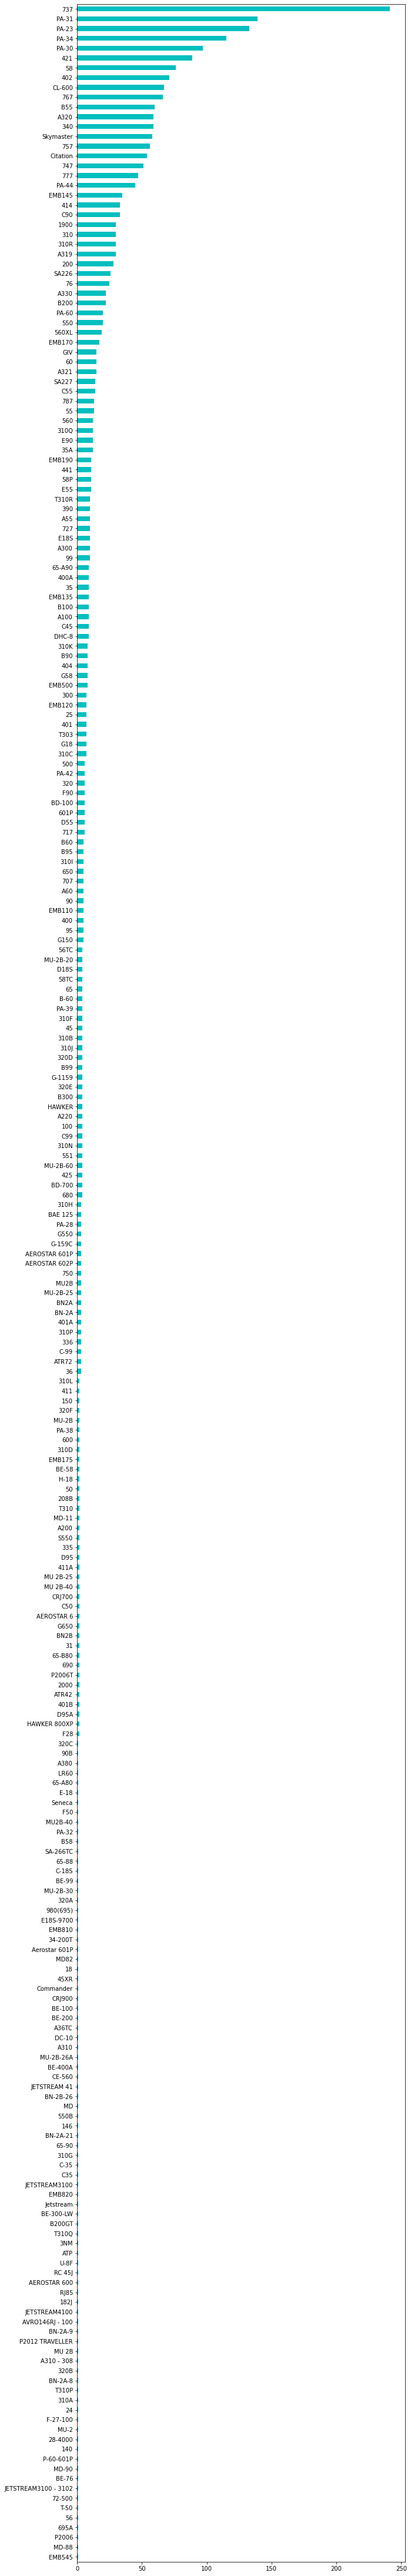

In [85]:
#Let's take a look at how they break down:
indicents_by_model = filtered_df['Model'].value_counts().sort_values()
indicents_by_model.plot(kind='barh', figsize=(10,80), color='c');

That's a lot of different aircraft models. Which aircraft are the lowest-risk? In order to get a broader view of manufacturer safety records, let's examine their injury and fatality counts seperately:

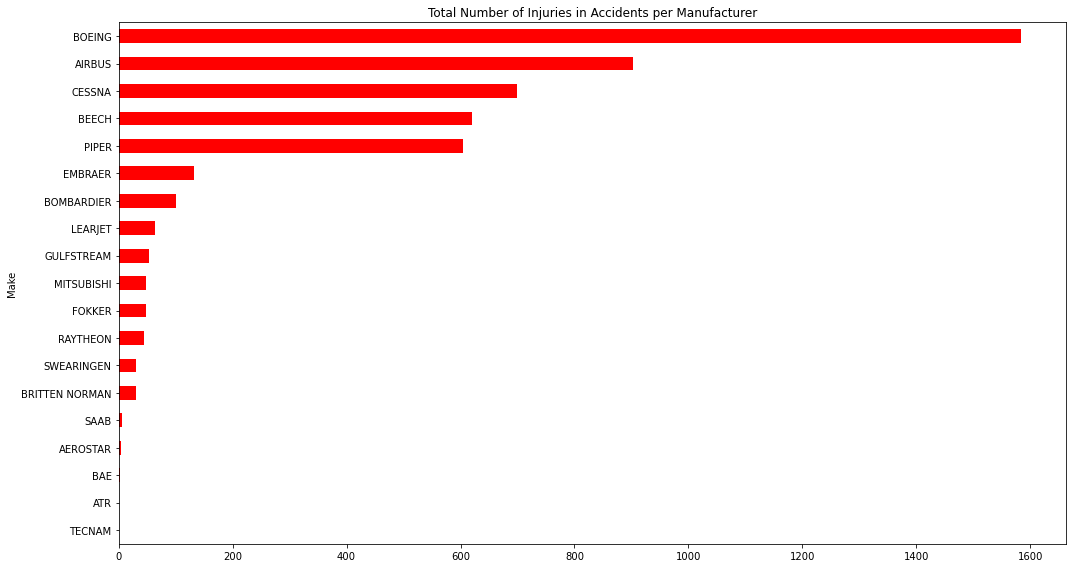

In [86]:
injuries_by_mnfr = filtered_df.groupby('Make')['total.inj.or.killed'].sum().sort_values()
injuries_by_mnfr.plot.barh(color='r', figsize=(15,8))
plt.title('Total Number of Injuries in Accidents per Manufacturer')
plt.tight_layout();

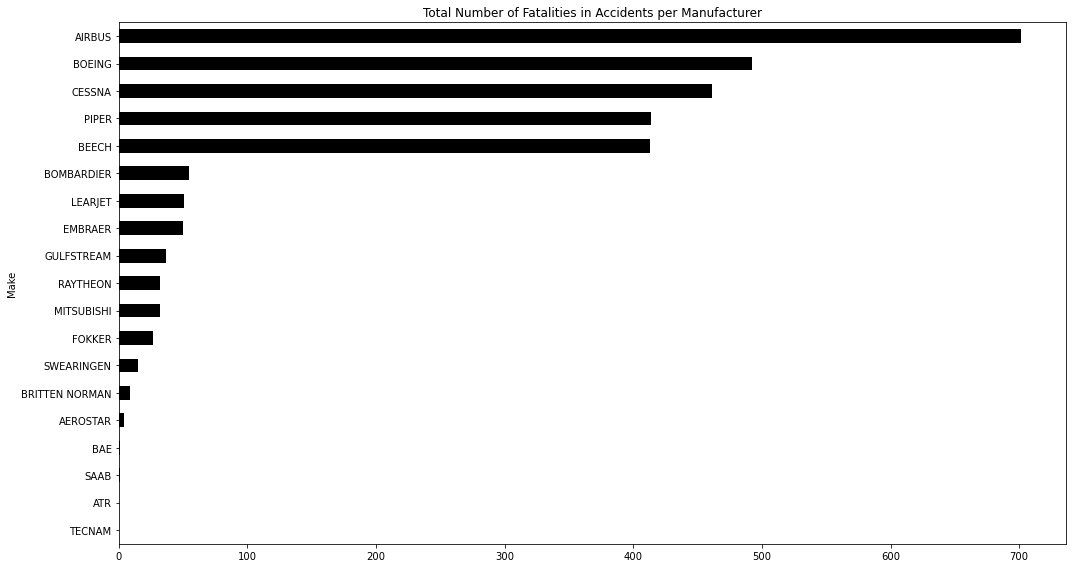

In [87]:
fatalities_by_mnfr = filtered_df.groupby('Make')['Total.Fatalities'].sum().sort_values()
fatalities_by_mnfr.plot.barh(color='k', figsize=(15,8))
plt.title('Total Number of Fatalities in Accidents per Manufacturer')
plt.tight_layout();

SO many Beoing injuries! Then it flips when it comes to fatalities with Airbus. Anway, when it comes to manufacturers, injuries & fatalities seem to cluster at the top with the same top five: Boeing & Airbus as the two larger aircraft makers, then Cessna, Piper, & Beech as the smaller aircraft makers. 

Fatalities & injuires drop significantly when we come to Embrear, Bombadier, Gulfstream, and Learjet, among others whose numbers then continue to progress downward, but by then, I wonder about many aircraft they've made in the first place. 

## Researching aircraft manufacturer size
With this thoroughly winnowed dataset, it's more feasible to compare the size of these manufacturers in order to know something akin to a percentage of incidents to planes made. 

From [this site](https://www.globenewswire.com/news-release/2023/04/05/2641465/0/en/Global-Business-Jet-Market-Size-Share-COVID-19-Impact-Forecast-2022-2027.html#:~:text=As%20of%20July%202022%2C%20Cessna,%2C%20and%207%25%2C%20respectively): 
- "As of July 2022, Cessna operated most of the global active business jets, followed by Bombardier, Gulfstream Aerospace Corporation, Dassault Aviation, and Embraer, accounting for 32%, 22%, 13%, 9%, and 7%, respectively."

Learjet was bought by Bombadier and, as of 2021, they're no longer making aircraft. However, they're still worth keeping here in case our stakeholder is interested in used aircraft. In any case, we can definitely say that Learjet isn't as big a manufacturer as Embraer & Bombadier. Gulfstream (now owned by General Dynamics) is also a major player. They only make private jets; Embraer & Bombadier make both regional aircraft *and* private ones. 

After these manufacturers, the rest either (1) fall off substantially in terms of size and/or (2) have been defunct for a while or (3) are relatively new (Swearingen is now SyberJet and their aircraft have only been around for a few years; the rest are records too old to be concerned with here).  

In [88]:
#narrow it down to the desired manufacturers
relevant_mfgs = ['AIRBUS', 'PIPER', 'CESSNA', 'EMBRAER', \
                'GULFSTREAM', 'BOMBARDIER', 'BOEING', \
                'BEECH', 'LEARJET']

filtered_df = filtered_df.loc[filtered_df['Make'].isin(relevant_mfgs)]
filtered_df['Make'].unique()

array(['CESSNA', 'BEECH', 'PIPER', 'EMBRAER', 'BOEING', 'GULFSTREAM',
       'LEARJET', 'BOMBARDIER', 'AIRBUS'], dtype=object)

Let's add in overall number of planes made by these top manufacturers to help narrow down who amongst them is the safest overall. Below, I input information I found on total number of planes made by these manufacturers. 

In [89]:
mfg_size_dict = {'AIRBUS': 13500, 'PIPER':144000, 'CESSNA':192500, \
                 'EMBRAER': 8000, 'GULFSTREAM':2000, 'BOMBARDIER':3000, \
                'BOEING': 24641, 'BEECH':54000, 'LEARJET':3034}

Now let's try dividing the number of fatalities by the number of planes made by each manufacturer.

In [90]:
#First, I'll turn the mfg size dictionary into a df
mfg_size_df = pd.DataFrame.from_dict(mfg_size_dict, orient='index', dtype='int', columns=['Total.Planes.Made'])
mfg_size_df

,Total.Planes.Made
AIRBUS,13500
PIPER,144000
CESSNA,192500
EMBRAER,8000
GULFSTREAM,2000
BOMBARDIER,3000
BOEING,24641
BEECH,54000
LEARJET,3034


In [91]:
#Then I'll turn the filtered_df's fatality & injury sum groupby objects into dictionaries:
fatal_dict = filtered_df.groupby('Make')['Total.Fatalities'].sum().to_dict()
injury_dict = filtered_df.groupby('Make')['Total.Injuries'].sum().to_dict()

In [92]:
fatal_dict

{'AIRBUS': 701.0,
 'BEECH': 413.0,
 'BOEING': 492.0,
 'BOMBARDIER': 55.0,
 'CESSNA': 461.0,
 'EMBRAER': 50.0,
 'GULFSTREAM': 37.0,
 'LEARJET': 51.0,
 'PIPER': 414.0}

In [93]:
#Now I can add those dictionaries to the df:
mfg_size_df['Total.Fatalities'] = mfg_size_df.index.map(fatal_dict)
mfg_size_df['Total.Injuries'] = mfg_size_df.index.map(injury_dict)
mfg_size_df

,Total.Planes.Made,Total.Fatalities,Total.Injuries
AIRBUS,13500,701.0,202.0
PIPER,144000,414.0,190.0
CESSNA,192500,461.0,239.0
EMBRAER,8000,50.0,83.0
GULFSTREAM,2000,37.0,16.0
BOMBARDIER,3000,55.0,46.0
BOEING,24641,492.0,1091.0
BEECH,54000,413.0,208.0
LEARJET,3034,51.0,13.0


In [94]:
#Then I can create the percentage columns easily:
mfg_size_df['Fatality.Percentage'] = round((mfg_size_df['Total.Fatalities'] / mfg_size_df['Total.Planes.Made'] ), 5)
mfg_size_df['Injury.Percentage'] = round((mfg_size_df['Total.Injuries'] / mfg_size_df['Total.Planes.Made']), 5)
mfg_size_df

,Total.Planes.Made,Total.Fatalities,Total.Injuries,Fatality.Percentage,Injury.Percentage
AIRBUS,13500,701.0,202.0,0.05193,0.01496
PIPER,144000,414.0,190.0,0.00288,0.00132
CESSNA,192500,461.0,239.0,0.00239,0.00124
EMBRAER,8000,50.0,83.0,0.00625,0.01038
GULFSTREAM,2000,37.0,16.0,0.01850,0.00800
BOMBARDIER,3000,55.0,46.0,0.01833,0.01533
BOEING,24641,492.0,1091.0,0.01997,0.04428
BEECH,54000,413.0,208.0,0.00765,0.00385
LEARJET,3034,51.0,13.0,0.01681,0.00428


In [95]:
#Now I just need to reset the index so the manufacturer names can show as their own column to make graphing easier:
mfg_size_df.reset_index(inplace=True)

In [96]:
mfg_size_df.rename(columns={'index':'manufacturer'}, inplace=True)

In [97]:
mfg_size_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   manufacturer         9 non-null      object 
 1   Total.Planes.Made    9 non-null      int32  
 2   Total.Fatalities     9 non-null      float64
 3   Total.Injuries       9 non-null      float64
 4   Fatality.Percentage  9 non-null      float64
 5   Injury.Percentage    9 non-null      float64
dtypes: float64(4), int32(1), object(1)
memory usage: 524.0+ bytes


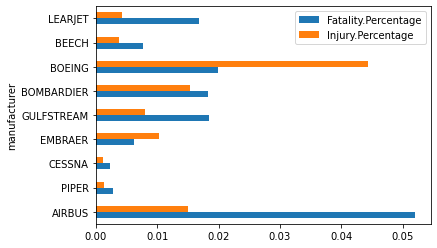

In [98]:
mfg_size_df.plot(x='manufacturer', y=['Fatality.Percentage', 'Injury.Percentage'], kind='barh');

I suppose it makes sense that Airbus and Boeing would stand out because their planes hold a *lot* more passengers than the Cessna and Piper planes with their 1-2 fatalities per fatal accident.

I think this shows that, at the end of the day, these are entirely different kinds of planes (of course). However, what *is* interesting is how you can see them break down by size. Two large airliner manufacturers, then a middle pack of regional planes and larger private jets, then the smaller private planes with Cessna, Piper, and maybe Beech as well. Remember, these are all 2+ engine planes. This gives us reason to break them down into these three categories.

Cessna & Piper are definitely the lowest here, but I wonder how much everyone breaks down by amount of indicents accross the board; I don't think there are a ton of 2+ engine Cessna and Pipers.

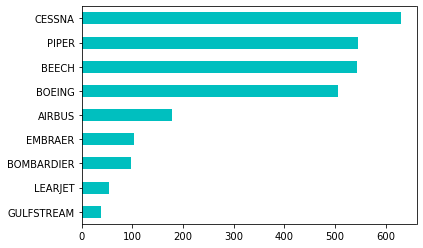

In [99]:
mfg_counts = filtered_df['Make'].value_counts().sort_values()
mfg_counts.plot(kind='barh', color='c');

Ah, I was wrong; there are a ton. Okay, so that means aircraft size (or "category"?), *especially in terms of how many people fit in them*, is playing a big role and we're not getting the entire picture with our percentage count. That means we need to split them up into these large-middle-small categories so we can compare apples-to-apples. 

The problem is we have a lot of models to look at:

In [100]:
len(filtered_df['Model'].unique())

215

In [101]:
filtered_df.head()

,Make,Model,Number.of.Engines,Total.Fatalities,Total.Uninjured,Publication.Date,Aircraft.damage_Destroyed,Aircraft.damage_Minor,Aircraft.damage_Substantial,Total.Injuries,total.inj.or.killed
8,CESSNA,401B,2.0,0.0,2.0,01-01-1982,0,0,1,0.0,0.0
25,CESSNA,414,2.0,8.0,0.0,03-01-1983,1,0,0,0.0,8.0
26,BEECH,BE-58,2.0,1.0,0.0,03-01-1983,1,0,0,0.0,1.0
33,PIPER,PA-34,2.0,2.0,0.0,04-01-1983,1,0,0,0.0,2.0
34,CESSNA,Skymaster,2.0,2.0,0.0,04-01-1983,1,0,0,2.0,4.0


Are we really going to look up the passenger capacity of each one? Hmm, even then, these models have different configurations. The 737 alone can fit between 138 and 230 seats! Hmm, what about incorporating the 'Total.Uninjured' column?

In [102]:
filtered_df['Total.Uninjured'].value_counts()

0.0      964
2.0      391
1.0      322
3.0      166
4.0      109
        ... 
222.0      1
137.0      1
19.0       1
69.0       1
177.0      1
Name: Total.Uninjured, Length: 250, dtype: int64

What if I did some sort of measure of injured-or-killed-to-uninjured to help shore up the insightfulness of the manufacturer comparisons? Below, I make a new column showing the percentage of injuries and fatalities per accident.

In [103]:
total_inj_or_killed = filtered_df['Total.Injuries']+filtered_df['Total.Fatalities']
total_people_on_board = filtered_df['Total.Injuries']+filtered_df['Total.Fatalities']+filtered_df['Total.Uninjured']
filtered_df['Percent.Injured.or.Killed'] = total_inj_or_killed / total_people_on_board
filtered_df['Percent.Injured.or.Killed'] = filtered_df['Percent.Injured.or.Killed'].fillna(0)

In [104]:
#inj_or_fatal_percentage = filtered_df.sort_values(['Percent.Injured.or.Killed'])
avg_inj_or_fatal_percentage_by_model = filtered_df.groupby('Model')['Percent.Injured.or.Killed'].mean()
avg_inj_or_fatal_percentage_by_model.sort_values(ascending=False, inplace=True)

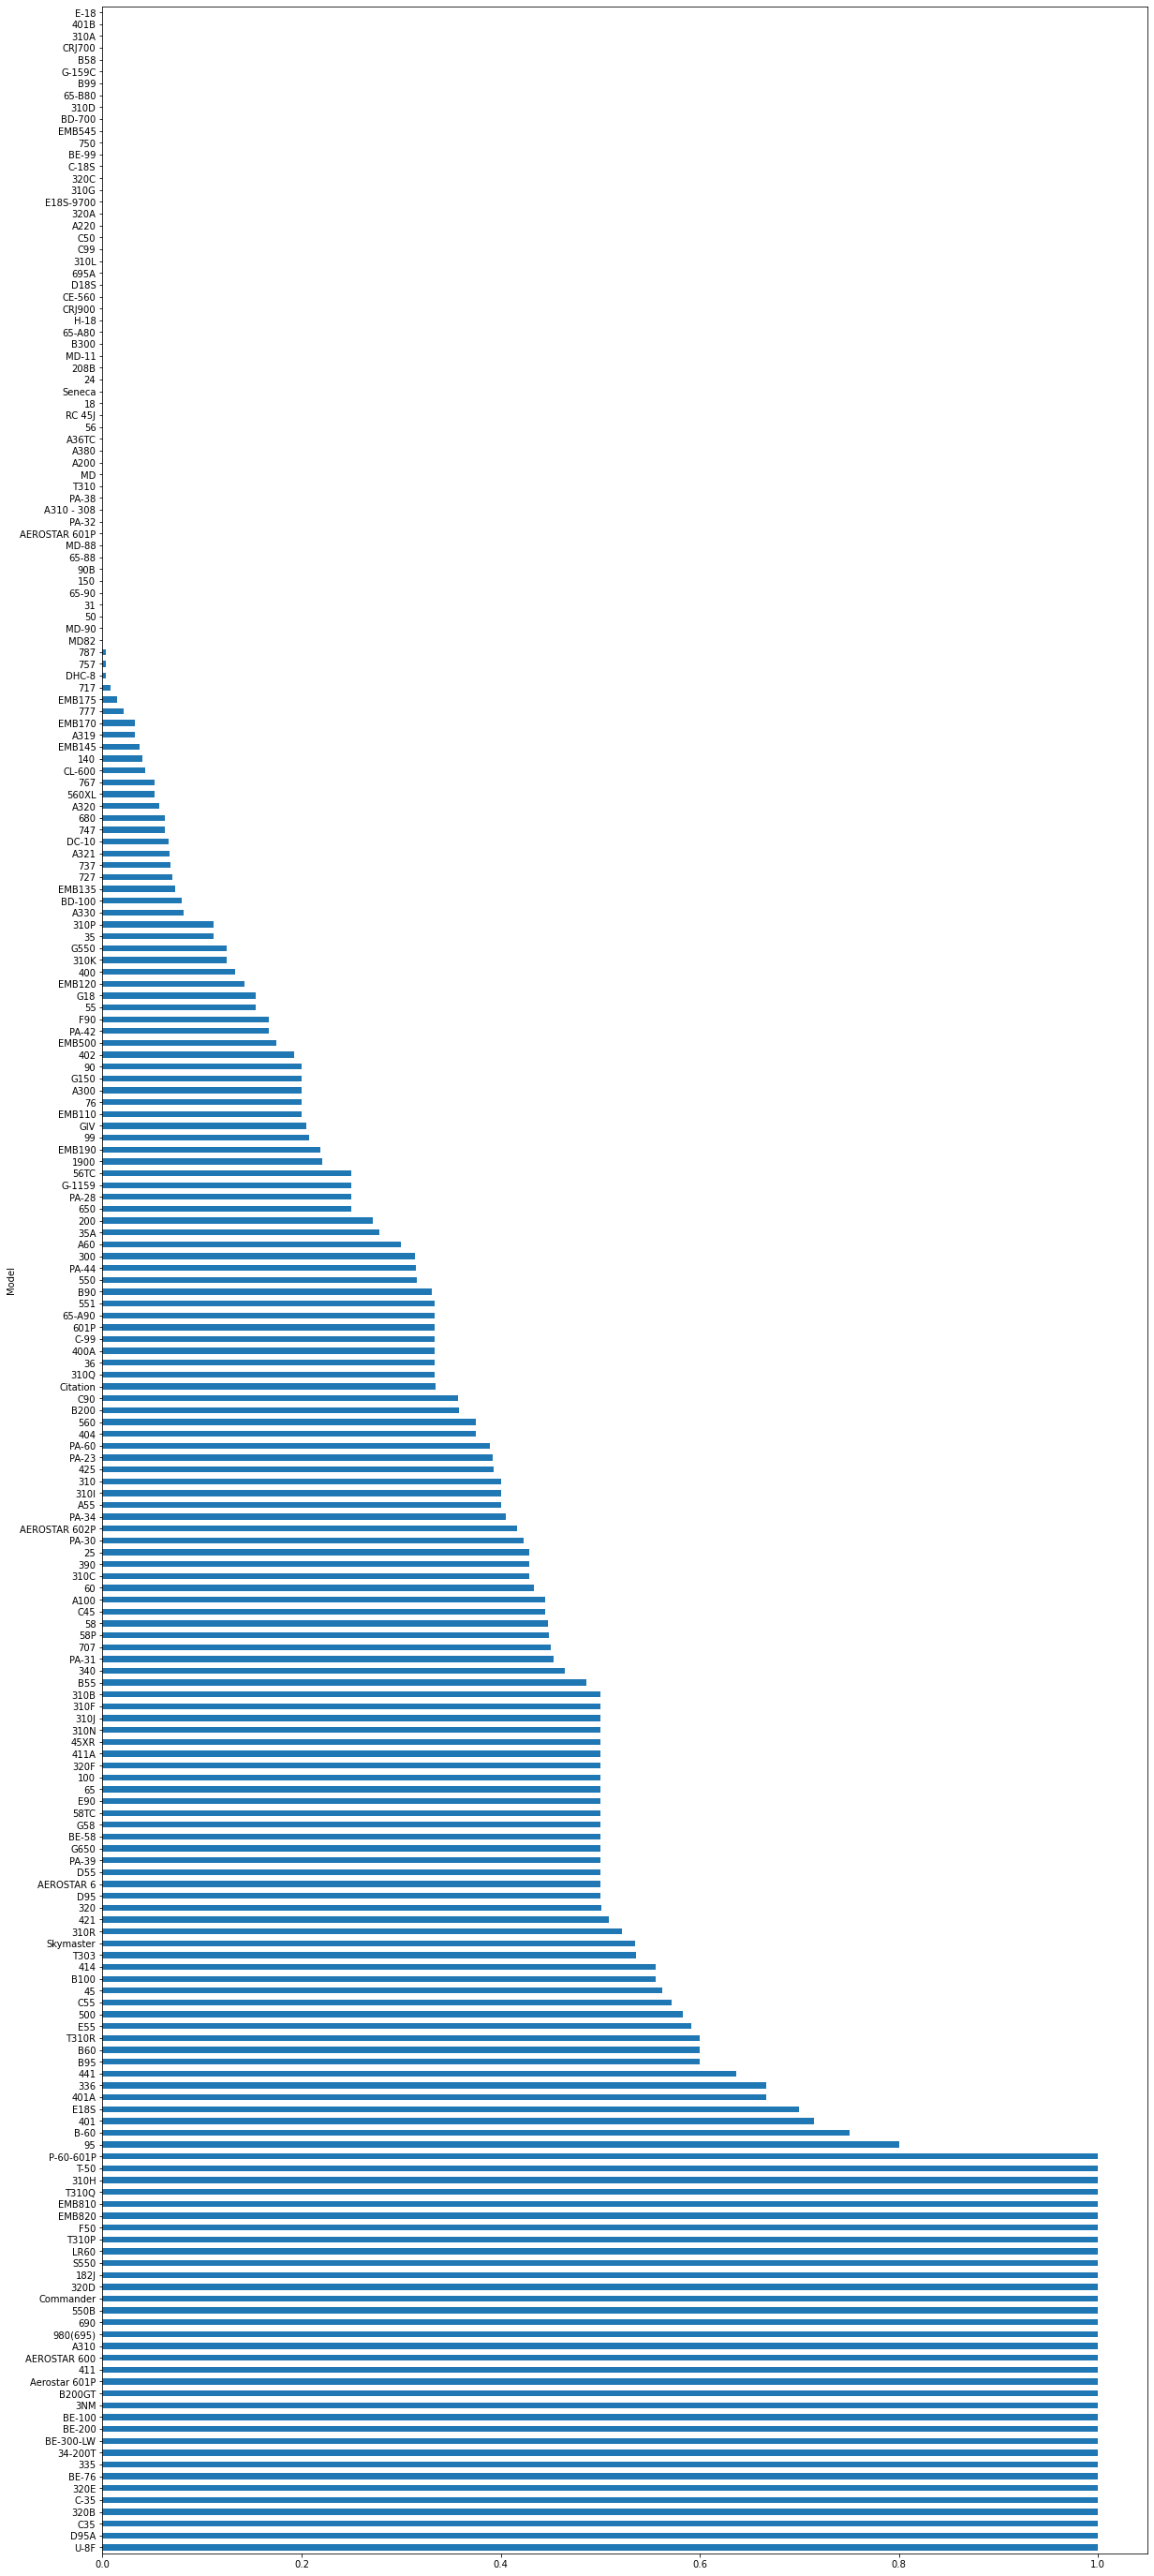

In [105]:
#inj_or_fatal_percentages.plot(x='Model', y='Percent.Injured.or.Killed');
avg_inj_or_fatal_percentage_by_model.plot(kind='barh', figsize=(20,50));

Well, all the big planes have the lower percentages because they hold more people and, unsurprisingly, all the little planes have the higher percentages; if one out of two people are injured, that's a 50% injury ratio (see the suspicious cluster of 50% rates). 

So, now that we have (reasonably) cleaned 'Make' and 'Model' columns in a well-filtered, relevant df, we're ready to make some conclusions here. We know (1) which manufacturers are the safest, but we also saw them break down by passenger capacity, which led us to (2) the safest models among those classes - but we need to find a good way to break those down. How many are we looking at, again?

In [106]:
len(filtered_df['Model'].unique())

215

Okay, I think this goes part-in-parcel with our first recommendation about planes with more than one engine. Yes, they're generally safer, but even that filtering measure still shows a lot of variety, particularly pertaining to passenger capacity. Subsequently, I think I can add a new column for these remaining 215 models where I break them down by size category.

In [107]:
#exporting the 'Models' column to Excel so I can add the size tier column in
unique_models = filtered_df['Model'].unique()
np.savetxt('filtered_df_Model_column.csv', unique_models, delimiter=',', fmt='%s')

As we've seen, seating capacity plays a big role. We'll say a "private aircraft" seating capacity is <= 15, "regional aircraft" is between 16-100 seats, and "large airliners" are < 100. At the end of the day, though, you can just kind of eyeball a private one from the other two (there aren't many regional aircraft with anywhere near 17 seats, but I will say the Beechcraft 1900C seats 19, but it *looks* like a (really small) regional aircraft).

In [108]:
#Reading the new column in from the now-finished Excel spreadsheet
PLR = pd.read_csv('filtered_df_Model_column_finished.csv')
PLR.head()

,Model,PLR
0,401B,p
1,414,p
2,BE-58,p
3,PA-34,p
4,Skymaster,p


In [109]:
#Turning that column into a dictionary
PLR_dict = PLR.set_index('Model')['PLR'].to_dict()
PLR_dict

{'401B': 'p',
 '414': 'p',
 'BE-58': 'p',
 'PA-34': 'p',
 'Skymaster': 'p',
 'PA-31': 'p',
 '340': 'p',
 'PA-23': 'p',
 'A310': 'l',
 'EMB110': 'p',
 'C45': 'p',
 'F50': 'p',
 'AEROSTAR 601P': 'p',
 '58': 'p',
 '402': 'p',
 'B200': 'p',
 '99': 'p',
 '200': 'p',
 'C55': 'P',
 '421': 'P',
 '401': 'P',
 '737': 'L',
 '90': 'P',
 'PA-44': 'P',
 '404': 'P',
 '56TC': 'P',
 'PA-60': 'P',
 'D18S': 'P',
 'B90': 'P',
 'A320': 'L',
 'PA-30': 'P',
 'B58': 'P',
 '707': 'L',
 'E18S': 'p',
 'B55': 'p',
 'PA-38': 'p',
 'Citation': 'p',
 'KC-135A': 'l',
 'PA-28': 'p',
 '65-A90': 'p',
 'G-159C': 'r',
 '65-88': 'p',
 'PA-32': 'p',
 '690': 'p',
 'D55': 'P',
 '601P': 'p',
 'E55': 'p',
 'C-18S': 'p',
 '727': 'l',
 'AEROSTAR 602P': 'p',
 '150': 'p',
 '411': 'p',
 'BE-99': 'p',
 'B95': 'p',
 'A60': 'p',
 '411A': 'p',
 '980(695)': 'p',
 'P-60-601P': 'p',
 'D95A': 'p',
 '65-90': 'p',
 '18': 'p',
 '140': 'r',
 '150F': 'P',
 '500': 'P',
 'C-35': 'P',
 'T303': 'P',
 'H-18': 'P',
 'PA-39': 'P',
 '58P': 'P',
 '60': '

In [110]:
#Mapping that dictionary to the 'Model' column:
filtered_df['Passenger.Capacity.Tier'] = filtered_df['Model'].map(PLR_dict)
filtered_df.head()

,Make,Model,Number.of.Engines,Total.Fatalities,Total.Uninjured,Publication.Date,Aircraft.damage_Destroyed,Aircraft.damage_Minor,Aircraft.damage_Substantial,Total.Injuries,total.inj.or.killed,Percent.Injured.or.Killed,Passenger.Capacity.Tier
8,CESSNA,401B,2.0,0.0,2.0,01-01-1982,0,0,1,0.0,0.0,0.0,p
25,CESSNA,414,2.0,8.0,0.0,03-01-1983,1,0,0,0.0,8.0,1.0,p
26,BEECH,BE-58,2.0,1.0,0.0,03-01-1983,1,0,0,0.0,1.0,1.0,p
33,PIPER,PA-34,2.0,2.0,0.0,04-01-1983,1,0,0,0.0,2.0,1.0,p
34,CESSNA,Skymaster,2.0,2.0,0.0,04-01-1983,1,0,0,2.0,4.0,1.0,p


In [111]:
#Did it work?
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2694 entries, 8 to 88869
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Make                         2694 non-null   object 
 1   Model                        2694 non-null   object 
 2   Number.of.Engines            2694 non-null   float64
 3   Total.Fatalities             2694 non-null   float64
 4   Total.Uninjured              2694 non-null   float64
 5   Publication.Date             2598 non-null   object 
 6   Aircraft.damage_Destroyed    2694 non-null   uint8  
 7   Aircraft.damage_Minor        2694 non-null   uint8  
 8   Aircraft.damage_Substantial  2694 non-null   uint8  
 9   Total.Injuries               2694 non-null   float64
 10  total.inj.or.killed          2694 non-null   float64
 11  Percent.Injured.or.Killed    2694 non-null   float64
 12  Passenger.Capacity.Tier      2539 non-null   object 
dtypes: float64(6), ob

In [112]:
filtered_df['Passenger.Capacity.Tier'] = filtered_df['Passenger.Capacity.Tier'].str.upper()
filtered_df['Passenger.Capacity.Tier'].value_counts()

P    1767
L     644
R     128
Name: Passenger.Capacity.Tier, dtype: int64

In [113]:
#Renaming the PLR values so they're easier to understand:
PLR_category_dict = {'P': 'private plane', 'R': 'regional airliner', 'L':'large airliner'}
filtered_df['Passenger.Capacity.Tier'] = filtered_df['Passenger.Capacity.Tier'].map(PLR_category_dict)
filtered_df['Passenger.Capacity.Tier'].value_counts()

private plane        1767
large airliner        644
regional airliner     128
Name: Passenger.Capacity.Tier, dtype: int64

In [114]:
len(filtered_df[filtered_df['Passenger.Capacity.Tier'].isna()])

155

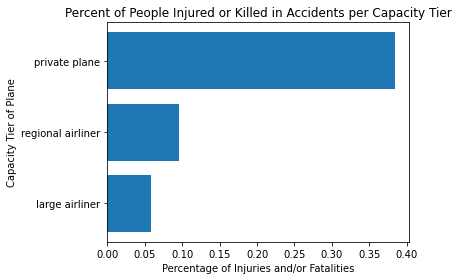

In [115]:
#How do they break down?
percent_inj_or_killed_by_capacity_tier = filtered_df.groupby('Passenger.Capacity.Tier')['Percent.Injured.or.Killed'].mean().sort_values()
#percent_inj_or_killed_by_capacity_tier.plot(kind='barh');
fig, ax = plt.subplots()
ax.barh(percent_inj_or_killed_by_capacity_tier.index, percent_inj_or_killed_by_capacity_tier.values)
ax.set_title('Percent of People Injured or Killed in Accidents per Capacity Tier')
ax.set_xlabel('Percentage of Injuries and/or Fatalities')
ax.set_ylabel('Capacity Tier of Plane')
plt.tight_layout();

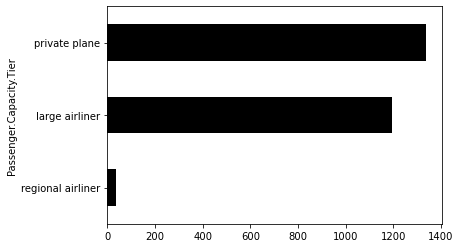

In [116]:
total_fatalities_by_capacity_tier = filtered_df.groupby('Passenger.Capacity.Tier')['Total.Fatalities'].sum().sort_values()
total_fatalities_by_capacity_tier.plot(kind='barh', color='k');

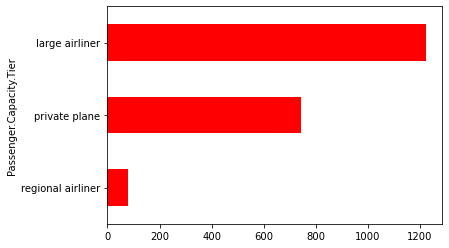

In [117]:
total_injuries_by_capacity_tier = filtered_df.groupby('Passenger.Capacity.Tier')['Total.Injuries'].sum().sort_values()
total_injuries_by_capacity_tier.plot(kind='barh', color='r');

Whoa, those regional aircraft are *appearing* to be a lot safer, but there are far fewer of them than the other two categories. Let's get those percentages by category for a fair shake:

In [118]:
injuries_by_capacity_tier = filtered_df.groupby('Passenger.Capacity.Tier')['Total.Injuries'].sum()
injuries_by_capacity_tier

Passenger.Capacity.Tier
large airliner       1224.0
private plane         744.0
regional airliner      80.0
Name: Total.Injuries, dtype: float64

In [119]:
capacity_tier_value_counts = filtered_df['Passenger.Capacity.Tier'].value_counts()
capacity_tier_value_counts

private plane        1767
large airliner        644
regional airliner     128
Name: Passenger.Capacity.Tier, dtype: int64

In [120]:
#numerators
private_injuries = injuries_by_capacity_tier['private plane']
regional_injuries = injuries_by_capacity_tier['regional airliner']
large_injuries = injuries_by_capacity_tier['large airliner']

#denominators
uninjured_by_capacity_tier = filtered_df.groupby('Passenger.Capacity.Tier')['Total.Uninjured'].sum()

private_uninjured = uninjured_by_capacity_tier['private plane']
regional_uninjured = uninjured_by_capacity_tier['regional airliner']
large_uninjured = uninjured_by_capacity_tier['large airliner']

#calculating percentages
private_injury_percentage = private_injuries / (private_injuries+private_uninjured)
regional_injury_percentage = regional_injuries / (regional_injuries+regional_uninjured)
large_injury_percentage = large_injuries / (large_injuries+large_uninjured)

private_injury_percentage, regional_injury_percentage, large_injury_percentage

(0.05927342256214149, 0.01931434089811685, 0.019705702418134397)

5.9% of private plane people in our filtered_df (whether pilots, crew, or passenger) were injured, while 1.93% of regional people and 1.97% of larger airline people were injured. This doesn't mean there's a 5.9% chance of injury when you ride or pilot a private plane; this statistic just pertains to our dataset on incidents & accidents. 

So, we *can* say that, **when there's an accident in a private plane, you're three times more likely to have been injured than in a regional or large airliner (when it comes to this filtered dataset).** 

Subsequently, we may be able to recommend that our stakeholder stick to regional or larger aircraft to minimize risk. However, let's also examine fatalities first.

In [121]:
fatalities_by_capacity_tier = filtered_df.groupby('Passenger.Capacity.Tier')['Total.Fatalities'].sum()

In [122]:
private_deaths = fatalities_by_capacity_tier['private plane']
regional_deaths = fatalities_by_capacity_tier['regional airliner']
large_deaths = fatalities_by_capacity_tier['large airliner']

private_death_percentage = private_deaths / (private_deaths+private_uninjured)
regional_death_percentage = regional_deaths / (regional_deaths+regional_uninjured)
large_death_percentage = large_deaths / (large_deaths+large_uninjured)

private_death_percentage, regional_death_percentage, large_death_percentage

(0.10184833041758576, 0.008542836221625579, 0.019216210556835204)

**Among the accidents in our dataset,** 10.18% of private aircraft people were killed as opposed to 0.86% of regional people and 1.92% of larger airliner folks. So, I'd definitely recommend regional or larger airliners for a lower-risk approach to purchasing & operating aircraft.

So, we've been able to show that aircraft with 2+ engines are lower risk and then, among those, regional and large airliners are even lower-risk. We've also been able to recommend certain manufacturers that are still around (or only recently went defunct). This regional/large airliner recommendation pretty much narrows those manufacturers down further to Boeing, Airbus, Embraer, Bombadier, and maybe a couple models by Gulfstream. Let's double check on that:

In [123]:
filtered_df.groupby('Passenger.Capacity.Tier')['Make'].unique()

Passenger.Capacity.Tier
large airliner                                        [BOEING, AIRBUS]
private plane        [CESSNA, BEECH, PIPER, EMBRAER, GULFSTREAM, LE...
regional airliner     [GULFSTREAM, BEECH, EMBRAER, BOMBARDIER, BOEING]
Name: Make, dtype: object

Ah, I see Beech also makes a regional aircraft. Okay, let's wrap up our last recommendation (or more like a set of recommendations): which models among these manufactuers to choose. 

I'm not going to make a decision for our stakeholder and exclude private planes here, so let's narrow it down to the top ten safest models by capacity tier. We'll define 'safest' by the smallest *percent* of combined injuries and accidents that model has had. 

In [124]:
large_airliners = filtered_df[filtered_df['Passenger.Capacity.Tier'] == 'large airliner']
regional_airliners = filtered_df[filtered_df['Passenger.Capacity.Tier'] == 'regional airliner']
private_planes = filtered_df[filtered_df['Passenger.Capacity.Tier'] == 'private plane']

In [125]:
unique_large_airliners = (len(large_airliners['Model'].unique()))
unique_regional_airliners = (len(regional_airliners['Model'].unique()))
unique_private_planes = (len(private_planes['Model'].unique()))

unique_large_airliners, unique_regional_airliners, unique_private_planes

(23, 12, 151)

Not exactly evenly-distributed there. The top-ten regional & large airliner models will take up a lot of the total ones we have, but I suppose even the total ones have been filtered down, so there's something. Okay, let's generate the combined injuries & fatalies per model per capacity tier. 

Let's start with the large_airliners. How does this look, again?

In [126]:
large_airliners['Model'].value_counts()

737      241
767       66
A320      59
757       56
747       51
        ... 
A310       1
MD         1
A380       1
MD-90      1
MD-88      1
Name: Model, Length: 23, dtype: int64

I could use the 'percent.injured.or.killed' column I made earlier, but that doesn't do justice to how long a plane has been around. For example, the newer A310 has had just one fatal accident, but everyone on board perished, meaningi it would show as a 100% fatal aircraft model. This is as opposed to the 737 with a far longer history and many more total fatalities, but since they've been spread out over more accidents, it would appear safer. 

Instead, I'll use the already-made 'Total.Injured.or.Killed' column in each capacity-tier df to see which are the lowest-risk. This is not a perfect solution; I would still need to incorporate total flight time for each plane model, but that sort of exterior research is beyond the scope of this project.

In [127]:
ki_sum_per_large_model = large_airliners.groupby('Model')['total.inj.or.killed'].sum().sort_values()
ki_sum_per_regional_model = regional_airliners.groupby('Model')['total.inj.or.killed'].sum().sort_values()
ki_sum_per_private_model = private_planes.groupby('Model')['total.inj.or.killed'].sum().sort_values()

These numbers will prove helpful once we do one last bit of cleaning. With a more reasonable amount of aircraft models in the mix and the only looking at the safest ones, we can afford to Google them to see which are still being made or haven't been discontinued for too long.

## Filtering airliners to only include those that are still flying commerically

### large airliners:


In [128]:
#Allow Pandas to show all the results instead of just the top and bottom five:
pd.set_option("display.max_rows", None)
ki_sum_per_large_model

Model
MD82       0.0
MD-88      0.0
MD-11      0.0
MD         0.0
A380       0.0
MD-90      0.0
A220       0.0
707        5.0
717        5.0
787        7.0
A300       7.0
DC-10     12.0
757       29.0
A319      38.0
747       59.0
727       79.0
767      139.0
A310     153.0
A321     160.0
A320     206.0
777      254.0
A330     271.0
737      993.0
Name: total.inj.or.killed, dtype: float64

Among those with no injuires or fatalities, the MD-80 & MD-90 series has been retired. The MD-11 still flies freight, but only a few are still flying passengers. So the large airliner with the best record is the Airbus A380, but it hasn't been around as long and far fewer units have been made than any of the Boeing aircraft on this list. 

Next would be the Airbus A220, which is new and still being made, so it makes the list. The 707 no longer flies commercially, but the 717 still flies, so it's on the list. The A300 is definitely still around and flying commerially as is the Boeing 787.

The DC-10 is retired, so we won't add it here, but the Boeing 757 is still pretty common. The A319 would also be on the list. The Boeing 747 is not as common and they're not made anymore, but they are still around and are a valid option for a used airliner, so they make the list here. 

The Boeing 727 isn't flying commercially any longer. The 767 is most commonly used as a freighter, but it still does commercial flights, so it can be included here. The Airbus A310 is still carrying passengers, so it rounds out the top ten lowest-risk large airliner list.

There are large gaps where the dashes are below; it really seems like maybe the top eight are the best and I just went to ten becuase that's a nice, round number.

1. Airbus A380
1. Airbus A220
3. Boeing 717
4. Airbus A300
4. Boeing 787
--------------
6. Boeing 757
6. Airbus A319
8. Boeing 747
--------------
9. Boeing 767
10. Airbus A310

In [129]:
#compiling that final list into its own df for graphing purposes
final_large_airliners_model_list = ['A380', 'A220', '717', 'A300', '787', \
                                    '757', 'A319', '747', '767', 'A310']
final_large_airliners = large_airliners[large_airliners['Model'].isin(final_large_airliners_model_list)]
#ensuring both the aircraft make and model appear
fla_graph = final_large_airliners.groupby(['Make','Model'])['total.inj.or.killed'].sum().sort_values(ascending=False)
fla_graph.index = fla_graph.index.map(lambda x: f'{x[0]} {x[1]}')

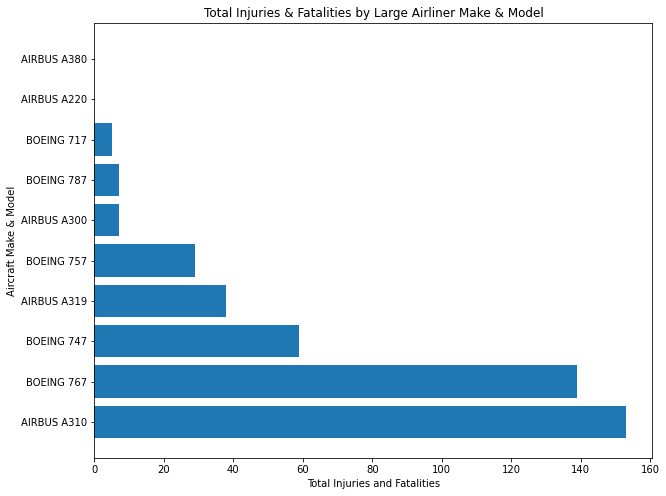

In [130]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(fla_graph.index, fla_graph.values)
ax.set_xlabel('Total Injuries and Fatalities')
ax.set_ylabel('Aircraft Make & Model')
ax.set_title('Total Injuries & Fatalities by Large Airliner Make & Model')
plt.tight_layout;

### regional airliners:

In [131]:
ki_sum_per_regional_model

Model
C99        0.0
CRJ700     0.0
G-159C     0.0
140        1.0
DHC-8      1.0
EMB120     2.0
EMB175     2.0
EMB145    18.0
EMB170    18.0
EMB190    18.0
EMB135    21.0
1900      34.0
Name: total.inj.or.killed, dtype: float64

The G-159C is old (first flight in 1958) and pretty rare, so I don't think it's the most solid business recommendation at this point. The same goes for the Beech C99; they stopped production in 1987 and most of the remaining ones are used to fly freight, so they don't make for a solid recommendation either. 

Subsequently, the first on the regional top-ten lowest-risk aircraft list would be the Bombadier CRJ700 series. The Embreaer 140 is being phased out by a lot of airlines, but is still flying and not too old, so it's a reasonable option with a great safety record and makes the list. 

The DHC-8 is an abbreviation for "De Havilland Canada Dash 8" and it is definitely still flying. The Embreaer 120, 175, 145, 170, 190, and 135 are all still flying as well, so they're included here.

The last one on the list, the Beech 1900, hasn't been manufactured since 2002 and isn't a very popular aircraft any longer, so it was left off this list. Below, the aircraft above the line have two or fewer injuries or fatalities on their record. Below the line, they have between 18-21. 

1. Bombadier CRJ700
2. Embreaer 140
3. De Havilland Canada Dash 8 (DHC-8)
4. Embreaer 120
5. Embreaer 175
-----------------
6. Embreaer 145
7. Embreaer 170
8. Embreaer 190
9. Embreaer 135

In [132]:
#compiling that final list into its own df for graphing purposes
final_regional_airliners_model_list = ['CRJ700', '140', 'DHC-8', 'EMB120', 'EMB175', 'EMB145', 'EMB170', 'EMB190', 'EMB135']
final_regional_airliners = regional_airliners[regional_airliners['Model'].isin(final_regional_airliners_model_list)]
#ensuring both the aircraft make and model appear
fra_graph = final_regional_airliners.groupby(['Make','Model'])['total.inj.or.killed'].sum().sort_values(ascending=False)
fra_graph.index = fra_graph.index.map(lambda x: f'{x[0]} {x[1]}')

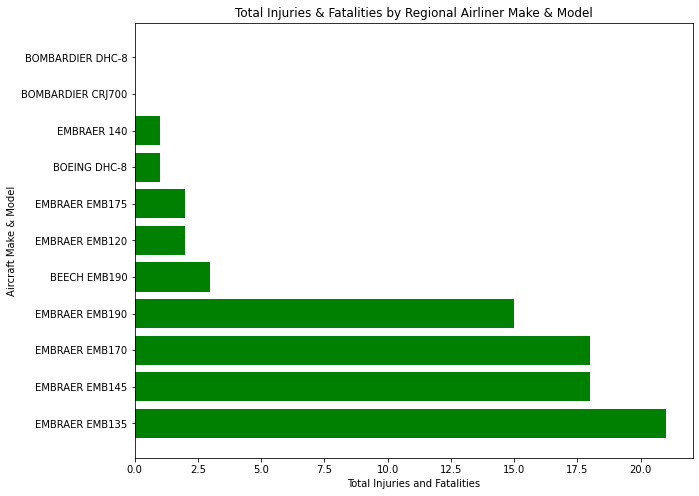

In [133]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(fra_graph.index, fra_graph.values, color='g')
ax.set_xlabel('Total Injuries and Fatalities')
ax.set_ylabel('Aircraft Make & Model')
ax.set_title('Total Injuries & Fatalities by Regional Airliner Make & Model')
plt.tight_layout;

### private planes:

In [134]:
len(ki_sum_per_private_model)

151

In [135]:
len(ki_sum_per_private_model[ki_sum_per_private_model == 0])

35

In [136]:
len(ki_sum_per_private_model[ki_sum_per_private_model <= 10])

114

There are so many more of these smaller, private planes here (162 total) than there were large or regional airliners. Furthermore, there are 45 without any injuries or fatalities and another 125 with ten or fewer. 

In order to give our stakeholder a more concise and realistic recommendation here, we may need to turn to other criteria besides injuries & fatalities. Let's examine the extent of damage in these incidents to see which show the absolute lowest-risk safety records. 

In [137]:
private_planes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1767 entries, 8 to 88869
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Make                         1767 non-null   object 
 1   Model                        1767 non-null   object 
 2   Number.of.Engines            1767 non-null   float64
 3   Total.Fatalities             1767 non-null   float64
 4   Total.Uninjured              1767 non-null   float64
 5   Publication.Date             1726 non-null   object 
 6   Aircraft.damage_Destroyed    1767 non-null   uint8  
 7   Aircraft.damage_Minor        1767 non-null   uint8  
 8   Aircraft.damage_Substantial  1767 non-null   uint8  
 9   Total.Injuries               1767 non-null   float64
 10  total.inj.or.killed          1767 non-null   float64
 11  Percent.Injured.or.Killed    1767 non-null   float64
 12  Passenger.Capacity.Tier      1767 non-null   object 
dtypes: float64(6), ob

In [138]:
#source: https://stackoverflow.com/questions/44531696/pandas-selecting-rows-for-which-groupby-sum-satisfies-condition
low_ki_private_planes = private_planes.groupby('Model').filter(lambda i: i['total.inj.or.killed'].sum()<=10)
low_ki_private_planes.shape

(390, 13)

Below, I make a new column that totals all the different kinds of damage, whether minor, substantial, or destroyed. However, those categories aren't equal; a minor damage incident is better than once in which the aircraft is destroyed. Subsequently, I differentiate them with weights below. These are arbitrary beyond their ability to distinguish whether an aircraft was destroyed or not. Later, I'll consider every aircraft model with less than a factor of 1 below. 

In [139]:
low_ki_private_planes['damage.count'] = low_ki_private_planes['Aircraft.damage_Minor']*0.25 + \
                                        low_ki_private_planes['Aircraft.damage_Substantial']*0.5 + \
                                        low_ki_private_planes['Aircraft.damage_Destroyed']

In [140]:
low_ki_private_planes.groupby('Model')['damage.count'].sum().sort_values()

Model
CE-560           0.00
BE-99            0.25
65-88            0.25
90B              0.25
18               0.25
Aerostar 601P    0.50
AEROSTAR 600     0.50
A36TC            0.50
E-18             0.50
56               0.50
E18S-9700        0.50
695A             0.50
EMB545           0.50
BE-76            0.50
65-90            0.50
C-18S            0.50
G550             0.50
G650             0.50
B58              0.50
45XR             0.50
U-8F             0.50
65-A80           0.50
34-200T          0.50
RC 45J           0.50
PA-32            0.50
3NM              0.50
182J             0.50
Seneca           0.50
24               0.50
BD-700           0.75
65-B80           0.75
T-50             1.00
Commander        1.00
31               1.00
AEROSTAR 6       1.00
208B             1.00
C35              1.00
B200GT           1.00
B300             1.00
C-35             1.00
150              1.00
BE-100           1.00
BE-200           1.00
BE-300-LW        1.00
C50              1.00
A200

Now that there is a more reasonable number of aircraft with fewer than a total of 1 in the 'damage.count' column, I can start going through and filtering out those that are too old. Since it looks like a plane's typical lifespan is [twenty to thirty years](https://www.aviationfile.com/how-long-does-a-commercial-aircraft-last/#:~:text=With%20proper%20maintenance%20and%20repair,to%20economic%20and%20operational%20reasons). Let's say those that are older than 30 years (so, haven't been produced since 1993) can be eliminated. 

In [141]:
private_models_to_drop = ['65-88', '18', 'BE-99', 'Aerostar 601P', 'AEROSTAR 600', \
                          'A36TC', 'B58', 'BE-76', 'C-18S', 'E-18', 'E18S-9700', \
                          'PA-32', 'RC 45J', 'Seneca', '56', 'U-8F', '3NM', '34-200T', '182J']

In [142]:
low_ki_private_planes = low_ki_private_planes[~low_ki_private_planes['Model'].isin(private_models_to_drop)]
low_ki_and_damage_private_planes = low_ki_private_planes.groupby('Model').filter(lambda s: s['damage.count'].sum()<1)
lkdpp_grouped = low_ki_and_damage_private_planes.groupby('Model')['damage.count'].sum().sort_values()
lkdpp_grouped

Model
CE-560    0.00
90B       0.25
24        0.50
45XR      0.50
65-90     0.50
65-A80    0.50
695A      0.50
EMB545    0.50
G550      0.50
G650      0.50
65-B80    0.75
BD-700    0.75
Name: damage.count, dtype: float64

In [143]:
len(low_ki_and_damage_private_planes.groupby('Model')['damage.count'].sum().sort_values())

12

In [144]:
#ensuring both the aircraft make and model appear
fpp_graph = low_ki_and_damage_private_planes.groupby(['Make','Model'])['damage.count'].sum().sort_values(ascending=False)
fpp_graph.index = fpp_graph.index.map(lambda x: f'{x[0]} {x[1]}')

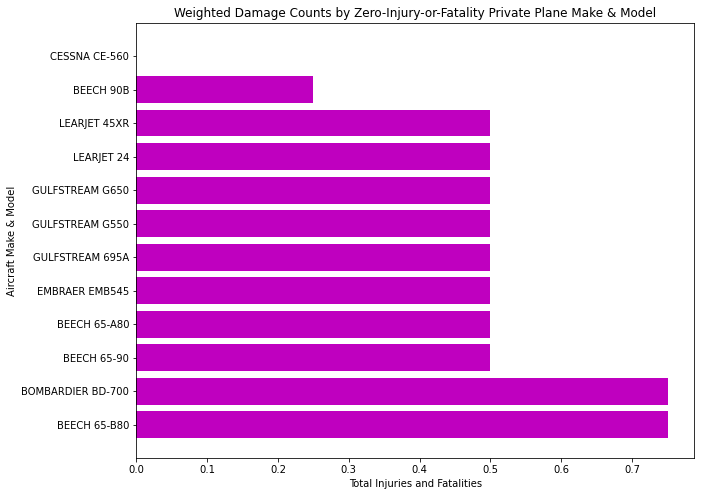

In [145]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(fpp_graph.index, fpp_graph.values, color='m')
ax.set_xlabel('Total Injuries and Fatalities')
ax.set_ylabel('Aircraft Make & Model')
ax.set_title('Weighted Damage Counts by Zero-Injury-or-Fatality Private Plane Make & Model')
plt.tight_layout;

# Summary of Results

I was able to make the following recommendations to our stakeholder whose primary concern is procuring & operating the lowest-risk aircraft:

1. Eliminate consideration of single-engine planes
2. Consider focusing on regional and/or large airliners, but since this may be cost-prohibitive, I also
3. provide the top make & model data for the lowest-risk planes among three passenger capacity tiers: private aircraft, regional planes, and large airliners.